# Разработка модели машинного обучения для прогноза стоимости автомобилей по VIN-коду

## Описание работы

**Цель работы:**
Построить и обучить модель машинного обучения (МО), которая позволит предсказать ориентировочную стоимость автомобиля по его VIN-коду.

**Планируемое использование результата работы:**
Заказчику необходим инструмент, который позволит его клиентам уточнить характеристики их автомобилей и оценить ориентировочную стоимость автомобиля.

**Входные данные:**
Заказчик предоставил набор данных о стоимости автомобилей производства Ford с указанием их VIN-кодов.

**Ключевые задачи работы:**
1. Изучить и подготовить данные для разработки модели машинного обучения (МО).
2. Определить условия работки моделей, разработать несколько моделей с использованием различных алгоритмов.
3. Оценить качество работы моделей. Выбрать лучшую модель.
4. Протестировать лучшую модель.
5. Разработать простейший интерфейс взаимодействия клиентов и модели.
6. Сформировать план на дальнейшую работу.

**Критерии заказчика:** Требования заказчика к метрике качества модели не установлены. Требований к скорости обучения и работы моделей не имеется.

**План работы:**

1. Изучение и подготовка данных.
    - Загрузка и изучение данных: изучить входные данные, оценить полноту и качество входных данных для достижения цели исследования; сформировать сводный дата-сет для дальнейшей работы; определить задачи предобработки данных сводного дата-сета;    
    - Преобработка данных: осуществить предобработку данных в части улучшения качества данных для дальнейшего анализа.
    - Исследовательский анализ данных: провести исследовательский анализ данных; оценить необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования, feature engineering: объединить или разделить необходимые данные, сформировать новые признаки, дополнительные категории и группы данных.
    - Корреляционный анализ данных, в том числе предварительный отбор признаков.
    - Подготовка данных: сформировать основные пайп-лайны, разделить дата-сет на выборки.
2. Разработка моделей.
    - Определение условий разработки моделей МО: определиться с критериями разработки моделей, метриками качества моделей, с используемыми алгоритмами, критериями сравнения моделей.
    - Основной этап моделирования: разработать модели, получить результаты для анализа их качества и скорости.
3. Оценка качества работы моделей: выбор лучшей модели.
4. Оценка качества работы лучшей модели на тестовой выборке.
5. Оценка важности признаков.
6. Разработка интефейса взаимодействия клиентов и модели.

**Итоговый вывод**

## Импорт библиотек

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import phik
import math
import time
import warnings
import seaborn as sns
import missingno as msno
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [3]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [4]:
from sklearn.model_selection import (GridSearchCV, 
                                     RandomizedSearchCV,
                                     train_test_split,
                                     cross_validate)
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_percentage_error)

## Объявление констант и установок

In [5]:
warnings.filterwarnings('default')

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
RANDOM_STATE = 1206

In [8]:
tqdm.pandas()

In [9]:
TEST_VALID_SIZE = 0.2

## Создание вспомогательных функций

In [10]:
def plot_pie(data: pd.Series, axes: matplotlib.axes.Axes, legend: str) -> None:
    """
    Функция, выводящая круговую диаграмму в соответствующую figure
    
    :param data: pandas.Series
    :param axes: matplotlib.axes.Axes
    :param legend: str
    :return: None; результат выводится на экран
    
    """    
    
    data.value_counts().plot(
        kind = 'pie', 
        autopct = '%1.0f%%',
        ylabel = '',
        title = 'Соотношение исследуемого признака.\nСтолбец ' + legend,
        ax = axes
    )

def analysis_cat_cols(df: pd.DataFrame, columns: list) -> None:
    """
    Функция, выводящая результаты анализа категориальных признаков 
    
    :param df: pandas.DataFrame; Дата-сет для которого проводится анализ
    :param columns: list; Список анализируемых столбцов дата-сета df
    :return: None; результат выводится на экран
    
    """    
    
    col_for_pie = []
    col_for_barh = []
    pie_plot = lambda x: True if x < 5 else False
    for col in columns:
        if pie_plot(df[col].nunique()):
            col_for_pie.append(col)
        else:
            col_for_barh.append(col)
    lenght = len(col_for_pie)
    rows = int(-(-lenght//4))
    if lenght == 1:
        legend = '[' + col_for_pie[0] + ']'
        plot_pie(df[col_for_pie[0]], None, legend)  
    elif rows > 1:
        cols = 4 if ((lenght % 4 != 1) or (lenght % 3 == 1)) else 3    
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i // cols, i % cols], legend)
        for k in range(i+1, cols*rows):
            fig.delaxes(axes[k // cols][k % cols])        
        fig.tight_layout()
    plt.show()
    
    for i in range(0, len(col_for_barh)):
        if df[col_for_barh[i]].nunique() <= 33:
            legend = '[' + col_for_barh[i] + ']'
            df[col_for_barh[i]].value_counts(ascending=True).plot(
                kind = 'bar', 
                title = 'Соотношение исследуемого признака.\nСтолбец ' + legend,
                ylabel = '',
            )   
            plt.xlabel('Категория')
            plt.ylabel('Количество элементов')
            plt.show() 
        else:
            print(f"Слишком много категорий:"
                  f"{df[col_for_barh[i]].nunique()}")
            print(f"Столбец {col_for_barh[i]} не может быть отображен")

In [11]:
def my_describe(df, column, desc=['hist', 'QR', 'describe', 'box', 'eject'],
                hist_desc=['Распределение\nисследуемого параметра',
                           'Единицы изменения\nисследуемого параметра',
                           'Частоста повторений\nисследуемого параметра'],
                box_desc=['Диаграмма размаха\nисследуемого параметра',
                           'Наименование\nисследуемого столбца',
                           'Единицы изменения\nисследуемого параметра']):
    """
    Функция, выводящая основные показатели для анализа количественных
    признаков
    
    :param df: pandas.DataFrame; дата-сет для которого проводится анализ
    :param column: str; столбец, для которого проводится анализ
    :param desc: list; способы вывода результатов анализа
    :param hist_desc: list; подписи для гистограммы
    :param box_desc: list; подписи для диаграммы размаха
    :return: None; результат выводится на экран
    
    """        
    
    legend_my_desc = 'Столбец' + ' [' + column + ']'
    
    if 'hist' in desc:
        bins = int(np.round(math.sqrt(len(df[column])), 0))
        df[column].plot(kind='hist', bins=bins, grid=True, legend=True)
        plt.title(hist_desc[0])
        plt.xlabel(hist_desc[1])
        plt.ylabel(hist_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
        
    quartiles = df[column].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    min_diagramm = max(quartiles[0.25] - 1.5*iqr, df[column].min())
    max_diagramm = min(quartiles[0.75] + 1.5*iqr, df[column].max())  
    
    if 'describe' in desc:
        print()
        print('Ключевые характеристики распределения:')
        print(df[column].describe().apply("{0:.2f}".format))

    if 'QR' in desc:
        print()
        print('Ключевые характеристики диграммы размаха:')
        print('IQR\t\t\t{0:.2f}'.format(iqr))
        print('Q1-1,5*IQR\t\t{0:.2f}'.format(quartiles[0.25] - 1.5*iqr))
        print('MIN диаграммы размаха\t{0:.2f}'.format(min_diagramm))
        print('Q3+1,5*IQR\t\t{0:.2f}'.format(quartiles[0.75] + 1.5*iqr))      
        print('MAX диаграммы размаха\t{0:.2f}'.format(max_diagramm))
        print()
        
    if 'box' in desc:
        df[column].plot(kind='box', grid=True, legend=False)
        plt.title(box_desc[0])
        plt.xlabel(box_desc[1])
        plt.ylabel(box_desc[2])
        plt.show()
    
    if 'eject' in desc:
        print('Ключевые характеристики выбросов:')
        print('Количество выбросов (вверх)\t{0:.0f}'
              .format(len(df[df[column] > max_diagramm])))
        print('Доля выбросов (вверх)\t\t{0:.2f}%'
              .format(len(df[df[column] > max_diagramm]) / len(df) * 100))
        print('Количество выбросов (вниз)\t{0:.0f}'
              .format(len(df[df[column] < min_diagramm])))
        print('Доля выбросов (вниз)\t\t{0:.2f}%'
              .format(len(df[df[column] < min_diagramm]) / len(df) * 100))

In [12]:
def corr_matrix(df, cols, corr_type, target=None, interval_cols=None):
    """
    Функция, формирующая матрицу корреляции
    
    :param df: pandas.Series; распределение, для которого проводится анализ
    :param cols: list
    :param corr_type: str, 'phik' или 'spearman' или ''
    :param target: str
    :return: None; результат выводится на экран
    
    """        
    
    new_cols = list(cols)
    if corr_type == 'phik':
        new_cols.append(target)
        corr = df[new_cols].phik_matrix(interval_cols=interval_cols)
    else:
        corr = df[new_cols].corr(method=corr_type)
    plt.figure(figsize = (30, 15))
    sns.heatmap(corr, vmin=-1, vmax=1,
                cmap='coolwarm', annot=True, fmt='.2f')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, va='top')
    plt.title('Матрица корреляции')
    plt.show()
    return corr

## Изучение и подготовка данных

### Загрузка и изучение данных 

Исходные данные представлены заказчиком в виде текстового файла с стоимости автомобилей производства Ford с указанием их VIN-кодов. Загрузим данные и отобразим первые символы.

In [13]:
with open('../data/vin_ford_train.txt', 'r', encoding='utf-8') as f:
    data = f.read()

In [14]:
data[:500]

'[2FMDK3JC4BBA41556:12500]мой[3FA6P0H75ER208976:14500]дядя [3FAHP08Z17R268380:1300][1FMCU0GX3DUC59421:15200]самых [1FAHP2E89DG119368:11600] верных[1FM5K8D82DGA16143:26400][1FTFW1CFXCFC23663:14000][2FMDK3JC6CBA90002:19500][1FTFW1CT8DKD06233:24400][1FMZU64W13UC28949:2900][2FMDK3JC9DBB30736:23500][1FMCU9D76CKC49193:12700][1FMCU9EG2CKA90624:20700][1FMCU0JX7EUA28208:21300][2FMGK5D85EBD31213:26700][2FMDK4KC6EBA72011:25100]правил [1FTFX1EF2EKE24350:26700][1ZVBP8EM0D5237253:11600][1FDNE1BW5BDA64735:13200'

В текстовом файле представлены строка (строки) с VIN-кодами и ценой, разделенные знаком ":" и заключенные в скобки "[]". Между элементами представлены различные символы. Используем регулярные выражения для выделения необходимых данных. Сначала найдем все пары VIN:цена

In [15]:
pattern = r'''
    \[                  # Блок начинается со знака [
    (?P<vin>([A-Z\d]+)) # Именованная группа с VIN-кодом 
                        # из одной или нескольких букв и цифр
    :                   # Блок содержит знак :
    (?P<price>(\d+))    # Именованная группа с ценой
                        # из одной или нескольких цифр
    \]                  # Блок заканчивается знаком ]
'''

In [16]:
# Выполним поиск и представим результат в формате словаря
result = [x.groupdict() for x in re.compile(pattern, re.X).finditer(data)]

In [17]:
len(result)

71885

Получили 71885 пар VIN:цена. Однако, VIN коды могут быть неверными (содержать невалидные символы). Проверим в регулярном выражении валидность VIN на возможные символы. При этом, с помощью регулярных выражений сразу разобьем VIN-код на блоки, которые описывают автомобиль в соответствии с таблицей.

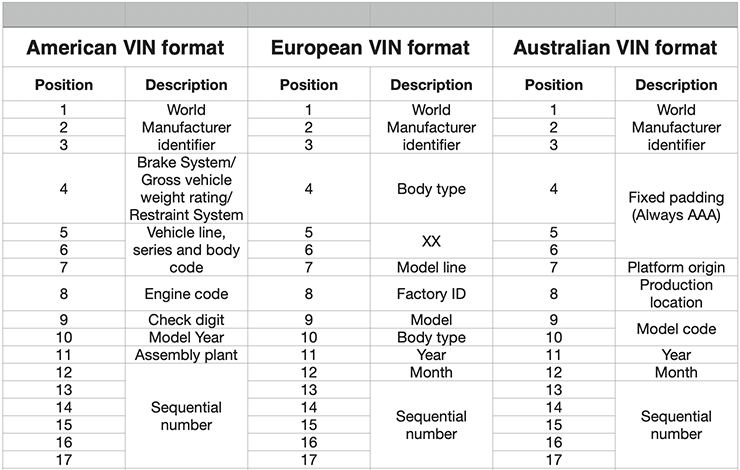

In [18]:
# Определим разрешенные символы в VIN-коде
ALLOWED_CHARS= [chr(x) for x in range(ord('A'), ord('Z')+1) 
                if chr(x) not in ['I', 'O', 'Q']]
ALLOWED_NUMS = [str(x) for x in range(1,10)] + ['0']

allowed = ''.join(ALLOWED_CHARS+ALLOWED_NUMS)
allowed

'ABCDEFGHJKLMNPRSTUVWXYZ1234567890'

In [19]:
# Определим заготовки блоков VIN-кода 
# для использования в регулярном выражении
wmi_re = f"(?P<wmi>[{allowed}]{{3}})"
prestraint_re = f"(?P<restraint>[{allowed}])"
model_re = f"(?P<model>[{allowed}]{{3}})"
engine_re = f"(?P<engine>[{allowed}])"
check_re = f"(?P<check>[{allowed}])"
year_re = f"(?P<year>[{allowed.replace('U','').replace('U','')}])"
plant_re = f"(?P<plant>[{allowed}])"
vis_re = f"(?P<vis>[{allowed}]{{3}}\\d{{3}})"

In [20]:
# Объединим блоки VIN-кода для поиска 
vin_full = f"{wmi_re}{prestraint_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{vis_re}"
vin_full

'(?P<wmi>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<restraint>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<model>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3})(?P<engine>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<check>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<year>[ABCDEFGHJKLMNPRSTVWXYZ1234567890])(?P<plant>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890])(?P<vis>[ABCDEFGHJKLMNPRSTUVWXYZ1234567890]{3}\\d{3})'

In [21]:
# Заготовка для регулярного выражения цены
vin_price = f"\\[(?P<vin>{vin_full}):(?P<price>\\d+)\\]"

In [22]:
# Выполним поиск и представим результат в формате словаря
result = [x.groupdict() for x in re.compile(vin_price).finditer(data)]

In [23]:
len(result)

71884

Получили 71884 валидных пар VIN:цена. Определим невалидный VIN-код

In [24]:
invalid_vin = f"\\[(?P<vin>(?!{vin_full})[A-Z\\d]{{17}}):(?P<price>\\d+)\\]"

In [25]:
re.compile(invalid_vin).findall(data)

[('1FM5K8D83DGB9100X', '', '', '', '', '', '', '', '', '26600')]

В найденом VIN-коде 17-й знак отличается от цифры.

In [26]:
# Сформируем дата-фрейм с полученными данными
dataset = pd.DataFrame(result)
dataset.head()

,vin,wmi,restraint,model,engine,check,year,plant,vis,price
0,2FMDK3JC4BBA41556,2FM,D,K3J,C,4,B,B,A41556,12500
1,3FA6P0H75ER208976,3FA,6,P0H,7,5,E,R,208976,14500
2,3FAHP08Z17R268380,3FA,H,P08,Z,1,7,R,268380,1300
3,1FMCU0GX3DUC59421,1FM,C,U0G,X,3,D,U,C59421,15200
4,1FAHP2E89DG119368,1FA,H,P2E,8,9,D,G,119368,11600


In [27]:
# Проверим размерность датасета
dataset.shape

(71884, 10)

In [28]:
# Изучим харатеристики датасета
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vin        71884 non-null  object
 1   wmi        71884 non-null  object
 2   restraint  71884 non-null  object
 3   model      71884 non-null  object
 4   engine     71884 non-null  object
 5   check      71884 non-null  object
 6   year       71884 non-null  object
 7   plant      71884 non-null  object
 8   vis        71884 non-null  object
 9   price      71884 non-null  object
dtypes: object(10)
memory usage: 5.5+ MB


#### Вывод по разделу "Загрузка и изучение входных данных" 

В ходе изучения входных данных был выполнен парсинг текстового файла с данными с использованием регулярных выражений (выделены VIN-коды и их составляющие) и сделаны следующие выводы по данным об их полноте и качестве для целей исследования:

1. Данные содержат 71884 валидных (по исползуемым символам) VIN-кода с указанием цены.
2. Целесообразно изменить тип данных столбца `price` на количественный. Все другие столбца оставим строками.
3. Кроме того, перед построением модели целесообразно проверить валидность VIN-кода с использованим проверочного символа в столбце `check`. Также, в будущем целесообразно проводить такую проверку при работе с пользовательскими VIN-кодами. Создадим соответствующую функцию.
4. Вместе с тем, необходимо проверить датасет на дубликаты VIN-кодов.
5. С учетом способа получения информации из текстового файла, пропусков в датасете не имеется.

### Преобработка данных

Прозведем предобработку данных на основании ранее сделанных выводов:

1. Преобразуем типы данных.
2. Проверим наличие дубликатов и обработаем их при необходимости.
3. Проверим VIN-коды на валидность.

Предварительно создадим копию входных данных для текущего этапа работы.

In [29]:
preprocessing_data = dataset.copy()

#### Преобразование типов данных

Исходя из выводов предыдущего этпа преобразуем тип данных столбца `price`.

In [30]:
preprocessing_data.price = preprocessing_data.price.astype(int)

In [31]:
# Проверим результат
preprocessing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71884 entries, 0 to 71883
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   vin        71884 non-null  object
 1   wmi        71884 non-null  object
 2   restraint  71884 non-null  object
 3   model      71884 non-null  object
 4   engine     71884 non-null  object
 5   check      71884 non-null  object
 6   year       71884 non-null  object
 7   plant      71884 non-null  object
 8   vis        71884 non-null  object
 9   price      71884 non-null  int32 
dtypes: int32(1), object(9)
memory usage: 5.2+ MB


#### Поиск и обработка дубликатов

В ходе первичного ознакомления с данными было выявлено, что в VIN-кодах могут быть дубликаты. В связи с тем, что большая часть столбцов сформирована из первого, то на наличие дубликатов проверим имеено по первому столбцу `vin`.

In [32]:
preprocessing_data.duplicated(subset='vin').sum()

0

Дубликатов не имеется.

#### Проверка валидности VIN-кода

Напишем функцию для проверки валидности VIN.

In [33]:
def check_vin(vin: str) -> bool:
    
    # Определим матрицы перевода символов VIN для проверки данных
    check_dict = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5,
                  'F': 6, 'G': 7, 'H': 8, 'J': 1, 'K': 2,
                  'L': 3, 'M': 4, 'N': 5, 'P': 7, 'R': 9,
                  'S': 2, 'T': 3, 'U': 4, 'V': 5, 'W': 6,
                  'X': 7, 'Y': 8, 'Z': 9,}
    check_weights = {1: 8,  2: 7,  3: 6,  4: 5,  5: 4,  6: 3,  
                     7: 2,  8: 10, 9: 0,  10: 9, 11: 8, 12: 7, 
                     13: 6, 14: 5, 15: 4, 16: 3, 17: 2,}
    s = 0
    i = 1
    for item in vin:
        if item in check_dict:
            item = check_dict[item]
        s += int(item) * check_weights[i]
        i += 1
    if s % 11 == 10:
        check_symbol = 'X'
    else:
        check_symbol = str(s % 11)
    if check_symbol == vin[8]:
        return True
    else:
        return False

In [34]:
preprocessing_data['control'] = (
    preprocessing_data.vin.progress_apply(check_vin)
)

100%|██████████| 71884/71884 [00:00<00:00, 120798.77it/s]


In [35]:
# Проверим выполнение преобразований
preprocessing_data.head()

,vin,wmi,restraint,model,engine,check,year,plant,vis,price,control
0,2FMDK3JC4BBA41556,2FM,D,K3J,C,4,B,B,A41556,12500,True
1,3FA6P0H75ER208976,3FA,6,P0H,7,5,E,R,208976,14500,True
2,3FAHP08Z17R268380,3FA,H,P08,Z,1,7,R,268380,1300,True
3,1FMCU0GX3DUC59421,1FM,C,U0G,X,3,D,U,C59421,15200,True
4,1FAHP2E89DG119368,1FA,H,P2E,8,9,D,G,119368,11600,True


In [36]:
# Проверим количество валидных VIN
preprocessing_data.control.sum()

71884

Все предстваленные VIN являются валидными.

#### Вывод по разделу "Преобработка данных" 

В ходе предобработки данных были достигнуты следующие результаты:

1. Преобразован тип данных столбца `price`. Целесообразно провести анализ стоимостей.
2. Дубликатов в данных не обнаруженю
3. Выявлено, что все представленные VIN коды валидны.
4. 
Предобработка данных завершена, данные готовы к дальнейшему анализу.

### Исследовательский анализ данных

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение категориальных признаков, применимость признаков для дальнейшей работы.
2. Распределение количественных признаков, в том числе, тип распределений для дальнейшей работы по разработке моделей машинного обучения, наличие выбросов и аномальных значений.
3. Необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования.

Предварительно создадим копию данных для текущего этапа работы, взглянем на данные и определим оригинальные категориальные и количественные признаки.

Заранее определимся, что некоторые признаки для обучения модели не будем использовать. А именно:
- столбец `vin` - полный код. Данные в указанном столбце уникальны и никакой информации в представленном виде не несут. Все другие столбцы созданы на его основе.
- столбец `check` - проверочное число. Данные в указанном столбце не влияют на стоимость автомобиля, а предназначены только для определения валидности VIN.
- стобец `vis` - серийный номер автомобиля. Данные в указанном столбце по большей части уникальные и никикой информации для стоимости автомобиля не несут.

In [37]:
eda_data = (
    preprocessing_data
    .drop(['vin', 'check', 'vis', 'control'], axis=1)
    .reset_index(drop=True)
    .copy()
)

Определим категориальные признаки

In [38]:
original_cat_features = list(eda_data.select_dtypes(include='O'))
original_cat_features

['wmi', 'restraint', 'model', 'engine', 'year', 'plant']

Количественных признаков в датасете не имеется.

In [39]:
original_num_features = []

Сформируем заготовки для перечня новых признаков

In [40]:
new_num_features, new_cat_features = [], []

#### Изучение столбцов с категориальными признаками

**Для каждого столбца с категориальными признаками:**
1. Построим круговую диаграмму (если количество категорий не превышает 4) или столбчатую диаграмму для столбцов с количеством категорий более 4.
2. Оценим репрезентативность классов каждого признака.

Исследуемые столбцы с категориальными признаками:
- `wmi`;
- `restraint`;
- `model`;
- `engine`;
- `year`;
- `plant`.

Для выполнения работ в соответствии с описанным подходом будем использовать созданные функции.

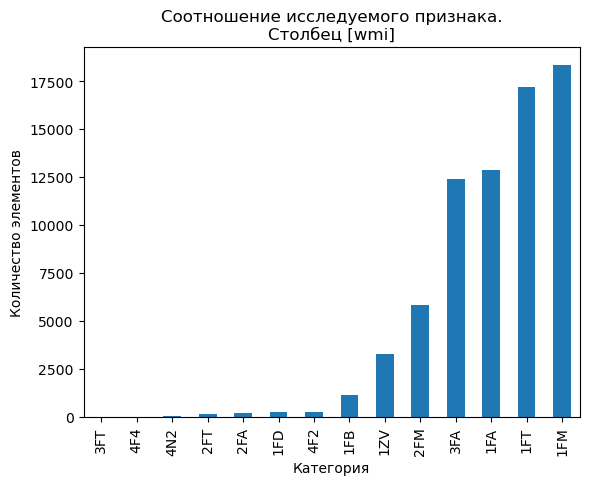

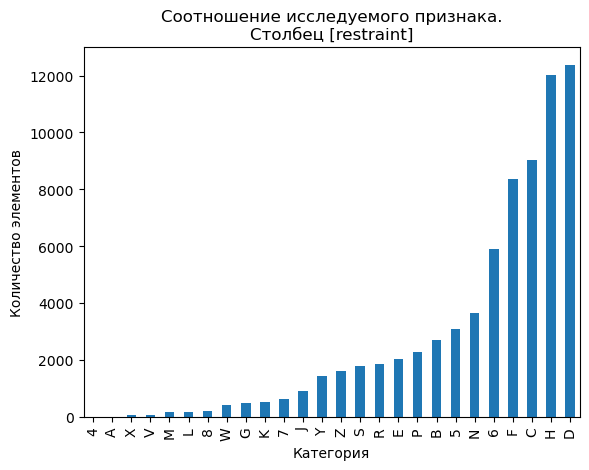

Слишком много категорий:365
Столбец model не может быть отображен


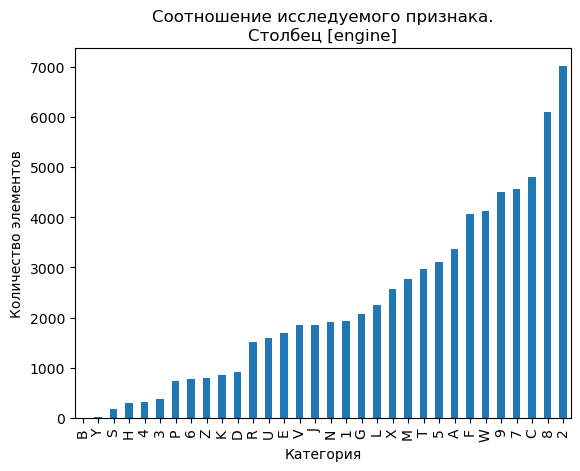

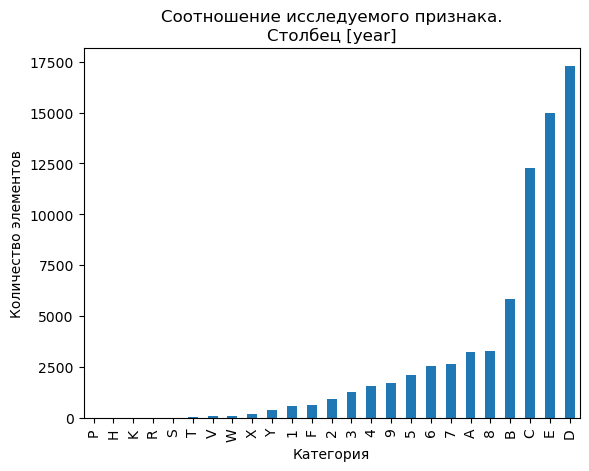

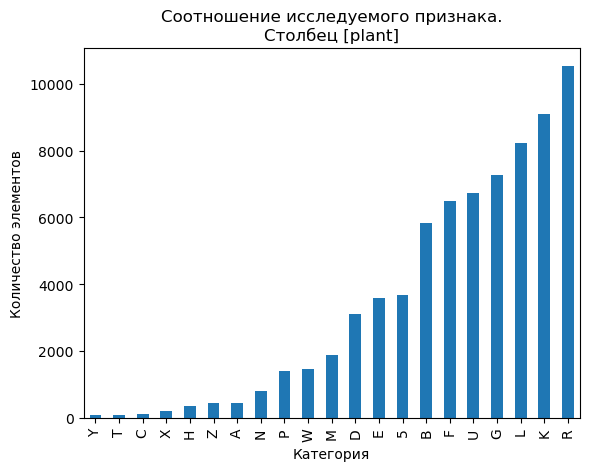

In [41]:
analysis_cat_cols(eda_data, original_cat_features)

**Промежуточный вывод**

Для всех категориальных признаков выявлено:
1. Бинарных признаков не имеется.
2. Все признаки имеют значительное количество категорий.
3. В дальнейшей работе требуется кодирование категориальных признаков:
    - использование OneHotEncoder нецелесообразно;
    - будем использовать OrdinalEncoder для моделей, не относящихся к линейным, посколько при их использовании не важны искусственные ранги категориальных признаков, линейные модели использователь не будем.
4. Исходя из данных в признаках, целесообразно создание новых признаков, в частности:
    - на основании признака `wmi` можно выделить регион выпуска автомобиля, используя 1-2 символа признка;
    - на основании признака `model` можно выделить тип автомобиля (Passenger Cars, Light Trucks & Multi-Purpose Passenger Vehicles) и его модель;
    - на основании признаков `restraint` и `model` можно выделить restraint types, GVWR class and brake type;
    - на основании признаков `engine` и `model` можно выделить характеристики двигателя автомобиля;
    - на основании признаков `year` и `model` можно выделить год выпуска автомобиля.
5. Для бейз-лайн модели создадим один признак, отражающий регион выпуска автомобиля.

**Создание нового признака**

С учетом ограниченного количества марок автомобилей, представленных в датасете (только FORD), определим уникальные значения первого символа признака `wmi`.

In [42]:
eda_data.wmi.apply(lambda x: x[0]).unique()

array(['2', '3', '1', '4'], dtype=object)

Используем соответствующую таблицу для уникальных значений регионов выпуска автомобилей.

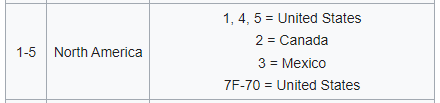

In [43]:
regions = {
    '1': 'United States',  '2': 'Canada', 
    '3': 'Mexico',  '4': 'United States',
    }

In [44]:
eda_data['region'] = eda_data['wmi'].progress_apply(lambda x: regions[x[0]])

100%|██████████| 71884/71884 [00:00<00:00, 976807.47it/s]


In [45]:
# Проверим результат
eda_data.sample(5)

,wmi,restraint,model,engine,year,plant,price,region
65447,3FA,H,P0G,A,C,R,8900,Mexico
33689,1FA,H,P3E,2,C,L,6800,United States
4808,1FA,F,P56,U,5,A,1000,United States
67309,1FM,C,U0H,X,D,U,18100,United States
60393,1FT,F,W1E,F,E,F,25700,United States


Другие признаки сформируем в рамках дальнейшего развития модели МО.

In [46]:
# Добавим созданный признак в список признаков
new_cat_features += ['region']

#### Изучение столбцов с количественными признаками

**II. Для каждого столбца с количественным параметром:**

1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемый столбец с количественным параметром - `price`, который является целевым признаком.

Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для количественных признаков в соответствии с описанным выше подходом.

**Столбец `price`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

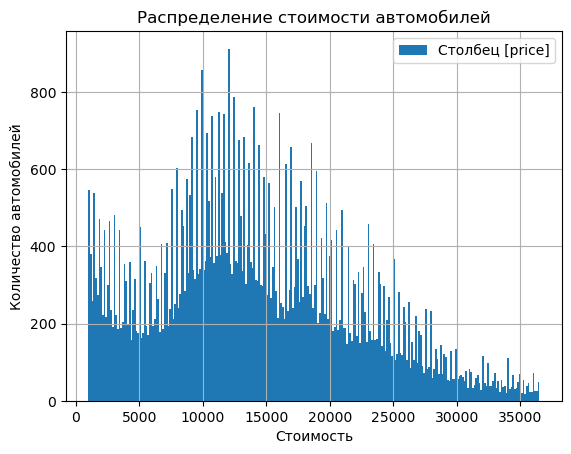


Ключевые характеристики распределения:
count    71884.00
mean     14321.45
std       7827.06
min       1000.00
25%       8800.00
50%      13500.00
75%      19500.00
max      36500.00
Name: price, dtype: object

Ключевые характеристики диграммы размаха:
IQR			10700.00
Q1-1,5*IQR		-7250.00
MIN диаграммы размаха	1000.00
Q3+1,5*IQR		35550.00
MAX диаграммы размаха	35550.00



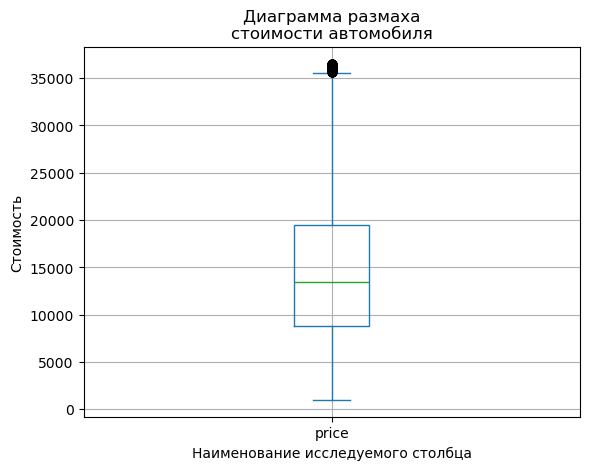

Ключевые характеристики выбросов:
Количество выбросов (вверх)	257
Доля выбросов (вверх)		0.36%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [47]:
my_describe(
    eda_data, 'price',
    hist_desc=[
        'Распределение стоимости автомобилей',
        'Стоимость',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nстоимости автомобиля',
        'Наименование исследуемого столбца',
        'Стоимость'
    ]
)

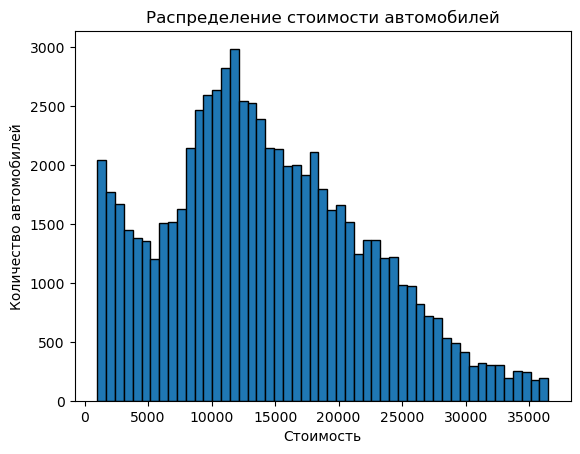

In [48]:
plt.hist(eda_data['price'], edgecolor='black', bins=51)
plt.title('Распределение стоимости автомобилей')
plt.xlabel('Стоимость')
plt.ylabel('Количество автомобилей')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики стоимости автомобилей:

* среднее и медиана близки - 14321.45 и 13500.00, выбросов не обнаружено;
* стоимость 50% автомобилей в диапазоне от 8800.00 до 19500.00;
* минимальное значение - 1000.00, максимальное - 36500.00.
    
Распределение длительности договоров визуально не может быть отнесено к типовым распределения непрерывных случайных величин.

Провал в распределении для стоимостей автомобилей около 6000.00 может быть связан с наложением автомобилей до 2010 года выпуска и после него. Указанные годы зашифрованы одним символом, который повторяется через 30 лет. В соответствии с анализом категорийных признаков целесообразно выделить правильный год выпуска автомобиля на основе данных о его модели.

Определим целевой признак для дальнейшей работы

In [49]:
target = 'price'

#### Вывод по разделу "Исследовательский анализ данных" 

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

**В части целевого признака:**
Выявлены ключевые характеристики стоимости автомобилей:

* среднее и медиана близки - 14321.45 и 13500.00, выбросов не обнаружено;
* стоимость 50% автомобилей в диапазоне от 8800.00 до 19500.00;
* минимальное значение - 1000.00, максимальное - 36500.00.

Выявлено, что количество автомобилей стоимостью около 6000 уменьшается. Это может быть связано с наложением стоимостей автомобилей до 2010 года выпуска и после него. Указанные годы зашифрованы одним символом, который повторяется через 30 лет. В соответствии с анализом категорийных признаков целесообразно выделить правильный год выпуска автомобиля на основе данных о его модели.

**В части категориальных признаков:**

1. Бинарных признаков не имеется.
2. Все признаки имеют значительное количество категорий.
3. В дальнейшей работе требуется кодирование категориальных признаков:
    - использование OneHotEncoder нецелесообразно;
    - будем использовать OrdinalEncoder для моделей, не относящихся к линейным, посколько при их использовании не важны искусственные ранги категориальных признаков, линейные модели использователь не будем.
4. Исходя из данных в признаках, целесообразно создание новых признаков, в частности:
    - на основании признака `wmi` можно выделить регион выпуска автомобиля, используя 1-2 символа признка;
    - на основании признака `model` можно выделить тип автомобиля (Passenger Cars, Light Trucks & Multi-Purpose Passenger Vehicles) и его модель;
    - на основании признаков `restraint` и `model` можно выделить restraint types, GVWR class and brake type;
    - на основании признаков `engine` и `model` можно выделить характеристики двигателя автомобиля;
    - на основании признаков `year` и `model` можно выделить год выпуска автомобиля.
5. Для бейз-лайн модели создадим один признак, отражающий регион выпуска автомобиля.

**Исследовательский анализ данных проведен, созданы новые признаки. Данные готовы к корреляционному анализу и отбору признаков для обучения**

Определим типы признаков для дальнейшей работы

In [50]:
cat_features = original_cat_features + new_cat_features
num_features = []

### Корреляционный анализ данных

Построим матрицу корреляции с использованием библиотеки 'PhiK', поскольку среди входных признаков много категориальных.

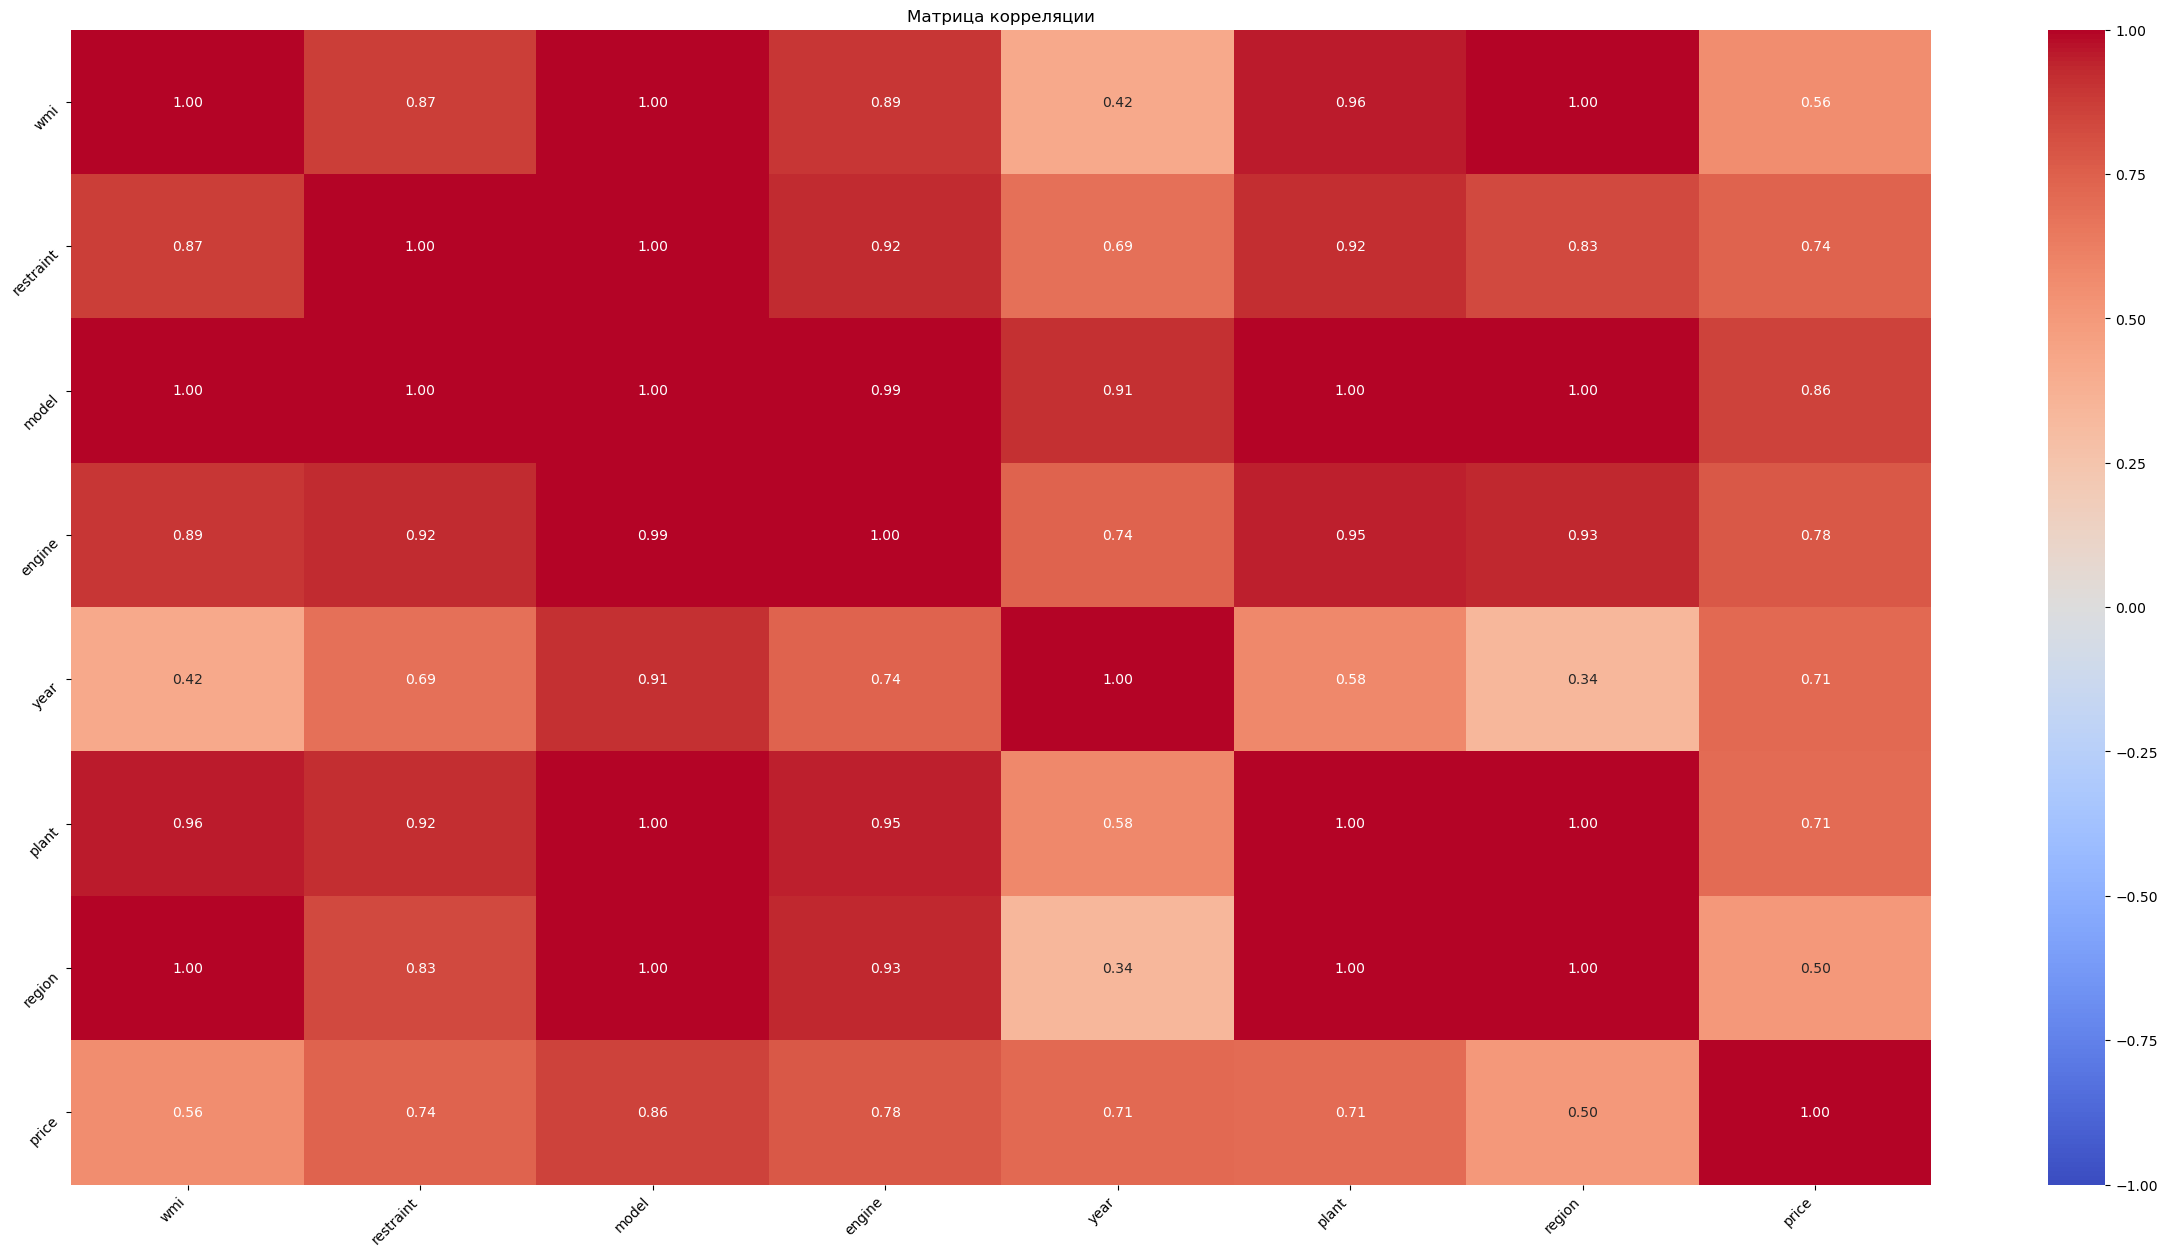

In [51]:
correlation = corr_matrix(
    eda_data,
    cat_features + num_features,
    'phik',
    target=target,
    interval_cols=target
)

#### Вывод по разделу "Корреляционный анализ данных" 

В результате проведенной работы среди признаков выявлены зависимости:
- между входными признакими очевидна существенная связь, как блоки одного VIN;
- среди входных признаков на целевой признак влияют `model`, `engine` и чуть меньше `restarint`, `year` и `plant`;
- созданный признак `region` и сам `wmi` оказывают минимальное влияние.

Проблем не обнаружено. Линейные модели МО использовать не будем.

## Подготовка данных к формированию моделей МО

Предварительно создадим копию входных данных для текущего этапа работы.

In [52]:
process_data = eda_data.reset_index(drop=True).copy()

С учетом сделанных ранее выводов сформируем пайплайны кодеровщика OrdinalEncoder() со значением-заглушкой для неизвестных значений

In [53]:
ord_pipe = Pipeline(
    [
        (
            'ord',  
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=-1
            )
        )
    ]
)

Для признаков, не вошедших в пайплайны кодирования и масштабирования используем прямую передачу.

In [54]:
remaider = 'passthrough'

Разделим дата-сет на тренировочную и тестовую выборки в отношении 1:4.

In [55]:
X = process_data.drop([target], axis=1)
y = process_data[target]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_VALID_SIZE, random_state=RANDOM_STATE)

In [57]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57507, 7), (57507,), (14377, 7), (14377,))

Создадим класс, обеспечивающий поток обучения различных моделей с учетом кросс-валидации и подбора гиперпараментров.

In [58]:
class FitPredictGo:
    def __init__(self, name, scoring):
        self.name = name
        self.scoring = scoring
        self.simple_fitted = None
        self.fitted = {}
        self.gs_fitted = None
        self.rs_fitted = None
        self.fit_type = None
    
    
    def fit(self, preprocessors, model, X_train, y_train):
        self.fit_type = 'simple fit'
        self.set_pipeline(preprocessors, model)
        self.fitted[self.fit_type] = self.pipe.fit(X_train, y_train)
        return 'Fitted'
    
    
    def fit_cv(self, preprocessors, model, 
               X_train, y_train, cv_folds, results=True):
        self.set_pipeline(preprocessors, model)
        self.fit_type = 'cv'
        cv = cross_validate(self.pipe,
                            X_train, y_train,
                            cv=cv_folds,
                            scoring=self.scoring)
        self.fitted[self.fit_type] = self.pipe.fit(X_train, y_train)
        if results:
            return self.get_results(cv)
        return cv
    
        
    def fit_search(self, preprocessors, model, param_grid, 
                   search_type, 
                   X_train, y_train, cv_folds, results=True):
        self.set_pipeline(preprocessors, model)
        self.fit_type = search_type
        if search_type == 'Grid':
            search = GridSearchCV(self.pipe, param_grid, 
                                  n_jobs=-1, cv=cv_folds,
                                  scoring=self.scoring)
        else:
            search = RandomizedSearchCV(self.pipe, param_grid,
                                        n_jobs=-1, cv=cv_folds,
                                        scoring=self.scoring,
                                        random_state=RANDOM_STATE)
        search.fit(X_train, y_train)
        self.fitted[self.fit_type] = search.best_estimator_
        if results:
            return self.get_results(search)
        return search
        
    
    
    def predict(self, X_test, predict_type):
        return self.fitted[predict_type].predict(X_test)            
    
    
    def predict_proba(self, X_test, predict_type):
        return self.fitted[predict_type].predict_proba(X_test)[:, 1]   
    
    
    def set_pipeline(self, preprocessors, model):
        estimators = preprocessors + [model]
        self.pipe = make_pipeline(*estimators)
        display(self.pipe)
    
    
    def get_results(self, results):
        if self.fit_type == 'cv':
            result = (
                self.name,
                round(results['fit_time'].mean(), 3),
                round(results['score_time'].mean(), 3),
                round((-1)*results['test_score'].mean(), 3),
                round(results['test_score'].std(), 3),
            )
            self.fit_type = None
        else:
            res = results.cv_results_
            idx = results.best_index_
            result = (
                f"{self.fit_type} enhanced {self.name}",
                round(res['mean_fit_time'][idx], 3),
                round(res['mean_score_time'][idx], 3),
                round((-1)*res['mean_test_score'][idx], 3),
                round(res['std_test_score'][idx], 3),
            )
            self.fit_type = None
        return result
    
    
    def get_best_estimator(self, predict_type):
        return self.fitted[predict_type]

Создадим класс, обеспечивающий сохранение результатов обучения для дальнейшего анализа моделей.

In [59]:
class Results:
    def __init__(self):
        self.df = pd.DataFrame([],
                               columns=[
                                   'Наименование модели',
                                   'Время обучения, сек.', 
                                   'Время предсказания, сек.',
                                   'Среднее значение метрики при CV',
                                   'СКО метрики при CV',
                               ])
        
        
    def update(self, new_row, show=False):
        del_row = new_row[0]
        self.df = self.df[~(self.df['Наименование модели'] == del_row)]
        try:
            rows_exist = max(self.df.index)
        except ValueError:
            rows_exist = -1
        finally:
            self.df.loc[rows_exist+1] = new_row
        if show:
            display(self.df.sort_values(
                by='Среднее значение ROC-AUC при CV', 
                ascending=False
            ))

### Вывод по разделу "Подготовка данных"

<a id='conclusion15' />

[Вернуться к началу](#begin)

Пайплайны подготовлены с учетом методов обработки данных, принятых на предыддущих этапах работы. Для потока обучения различных моделей, проведения кросс-валидации создан класс FitPredictGo. Для сохранения результатов кросс-валидации и последующего анализа моделей создан класс Results.
В ходе работы также подготовлены тренировочная и тестовая выборки. Данные тестовой выборки будут использованы только в конце работы.

## Разработка моделей

### Определение условий разработки моделей

<a id='step21' />

[Вернуться к началу](#begin)

**Постановка задачи**

В результате проведенной работы по анализу данных и анализа задачи заказчика определено, что в работе необходимо решить задачу регрессии - необходимо спрогнозировать количественный признак, отражающий стоимость автомобилей.
Для решения задачи построим несколько моделей, за исключением линейных моделей.

**Выбор метрики**

Требования заказчика к метрике качества модели не установлены.  

Для поставленной задачи регрессии целесообразно оценивать ошибку предсказания модели. При этом, ввиду отсутствия выбросов в данных, допустимо использованием метрик MSE и RMSE. В целях интерпретируемости метрики выберем RMSE. 

Вместе с тем, для еще большей интерпретируемости оценим метрику MAPE, отражающую средную абсолютную ошибку в процентах.

**Необходимый уровень метрики**

Заказчиком не установлены требования к метрикам. В связи с этим, оценим указанные метрики для Dummy модели, предсказывающей случайные значения и постараемся добиться минимальных значений метрик для других моделей.

**Дополнительные условия**

Заказчиком не установлены дополнительные критерии оценки качества моделей: время обучения модели и время предсказания модели.

Однако, при моделировании мы будем замерять указанные характеристики и сохраним их для последующего анализа.

Установим дополнительную константу для указания количества блоков для кросс-валидации.

In [60]:
cv_folds = 3

In [61]:
scoring = 'neg_root_mean_squared_error'

**План основного этапа моделирования**

На основании сделанных выводов и поставленных задач на основном этапе моделирования выполним построение следующих моделей:
1. **DummyRegressor()**.
2. **KNeighborsRegressor()**.
3. **DecisionTreeRegressor()**.
4. **CatBoostRegressor()**

Для каждой модели:
1. Построим пайп-лайн предобработки данных. 
2. Обучим модель с учетом кросс-валидации. 
3. Зафиксируем среднее время обучения на тренировочных данных, предсказания на валидационных данных.
4. Зафиксируем значения выбранной метрики по результатам кросс-валидации.
5. Определим сетку подбора гиперпараметров.
6. Найдем наилучшую модель с использованием RandomizedSearchCV.
7. Зафиксируем среднее время обучения на тренировочных данных, предсказания на валидационных данных.
8. Зафиксируем значения выбранной метрики по результатам кросс-валидации.

#### Вывод по разделу "Определение условий разработки моделей" 

<a id='conclusion21' />

[Вернуться к началу](#begin)

В результате анализа целей и задач работы определены условия разработки моделей МО и сформирован план основного этапа моделирования.

### Основной этап моделирования

<a id='step22' />

[Вернуться к началу](#begin)

Выполним шаги в соответствии с планом, определенным в предыдущем шаге.

Определим перечень моделей для обучения. В словарь в будущем внесем результаты обучения моделей.

In [62]:
names = {
    'DummyRegressor()': None,
    'KNeighborsRegressor()': None,
    'DecisionTreeRegressor()': None,
    'CatBoostRegressor()': None,
}

Построим пайп-лайны предобработки данных

In [63]:
preprocessor = ColumnTransformer(
    [
        ('ord', 
         ord_pipe, 
         cat_features)
    ],
    remainder='passthrough'
)

In [64]:
preprocessors = {
    'DummyRegressor()': [preprocessor],
    'KNeighborsRegressor()': [preprocessor],
    'DecisionTreeRegressor()': [preprocessor],
    'CatBoostRegressor()': [None],
}

Определим инициализационные модели для кросс-валидации

In [65]:
models = {
    'DummyRegressor()': DummyRegressor(),
    'KNeighborsRegressor()': KNeighborsRegressor(),
    'DecisionTreeRegressor()': DecisionTreeRegressor(
        random_state=RANDOM_STATE
    ),
    'CatBoostRegressor()': CatBoostRegressor(verbose=0, 
                                               n_estimators=100,
                                               cat_features=cat_features,
                                               random_seed=RANDOM_STATE),
}

Определим сетки подбора гиперпараметров

In [66]:
param_grid_dtr = [
    {
        'decisiontreeregressor__max_features': range(10, 30),
        'decisiontreeregressor__max_depth': range(13, 20)
    },
]

param_grid_cat = [
    {
        'catboostregressor__n_estimators': [50, 100],
        'catboostregressor__learning_rate': [.1, .05, .03],
        'catboostregressor__depth': [4, 6, 10],
        'catboostregressor__l2_leaf_reg': [1, 2]
        
    },
]

In [67]:
param_grids = {
    'DummyRegressor()': None,
    'KNeighborsRegressor()': None,
    'DecisionTreeRegressor()': param_grid_dtr,
    'CatBoostRegressor()': param_grid_cat,
}

Выполним обучение. Для каждой модели отображается пайп-лайн для контроля.

In [68]:
%%time

results = Results()
for name in names.keys():
    print(f"{name}, CV")
    model = FitPredictGo(name, scoring)
    start = time.time()
    result = model.fit_cv(preprocessors[name], models[name],
                          X_train, y_train, cv_folds, True)    
    time_cv = round(time.time() - start, 3)
    results.update(result)
    print(f"--> Done. CV Time = {time_cv} секунд")
    if param_grids[name] is not None:
        print()
        print(f"{name}, Randomized Search")
        start = time.time()
        result = model.fit_search(preprocessors[name], models[name],
                                  param_grids[name], 'Randomized',
                                  X_train, y_train, cv_folds, True)
        time_rs = round(time.time() - start, 3)
        results.update(result)
        print(f" RandomizedSearch Time = {time_rs} секунд")
    names[name] = model
    print()
print('All Done')

DummyRegressor(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['wmi', 'restraint', 'model',
                                                   'engine', 'year', 'plant',
                                                   'region'])])),
                ('dummyregressor', DummyRegressor())])

--> Done. CV Time = 0.635 секунд

KNeighborsRegressor(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['wmi', 'restraint', 'model',
                                                   'engine', 'year', 'plant',
                                                   'region'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

--> Done. CV Time = 1.696 секунд

DecisionTreeRegressor(), CV


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['wmi', 'restraint', 'model',
                                                   'engine', 'year', 'plant',
                                                   'region'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1206))])

--> Done. CV Time = 0.759 секунд

DecisionTreeRegressor(), Randomized Search


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['wmi', 'restraint', 'model',
                                                   'engine', 'year', 'plant',
                                                   'region'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=1206))])

 RandomizedSearch Time = 2.373 секунд

CatBoostRegressor(), CV


Pipeline(steps=[('nonetype', None),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000002101BF5BA90>)])

--> Done. CV Time = 14.205 секунд

CatBoostRegressor(), Randomized Search


Pipeline(steps=[('nonetype', None),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor object at 0x000002101BF5BA90>)])

 RandomizedSearch Time = 29.735 секунд

All Done
CPU times: total: 1min 15s
Wall time: 49.4 s


#### Вывод по разделу "Основной этап моделирования" 

В ходе работы в соответствии с определенным планом были обучены четыре модели, некоторые из них в двух вариантах обучения: без изменения дополнительных гиперпараметров (на основе инициализационной модели) и с учетом подбора гиперпараметров. В результате получены количественные показатели ключевых критериев для дальнейшего анализа.

## Оценка качества работы моделей: выбор лучшей модели

Отобразим результаты моделирования в виде сводной таблицы количественных показателей критериев всех моделей.

In [69]:
sorted_results = results.df.sort_values(by='Среднее значение метрики при CV', 
                                        ascending=True)
sorted_results

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
2,DecisionTreeRegressor(),0.134,0.043,2804.918,11.940
3,Randomized enhanced DecisionTreeRegressor(),0.125,0.047,2805.030,14.089
4,CatBoostRegressor(),3.437,0.068,2832.739,19.688
5,Randomized enhanced CatBoostRegressor(),17.346,0.170,2885.559,16.585
1,KNeighborsRegressor(),0.177,0.291,3017.714,15.163
0,DummyRegressor(),0.096,0.063,7829.249,33.282


Визуализируем результы моделирования

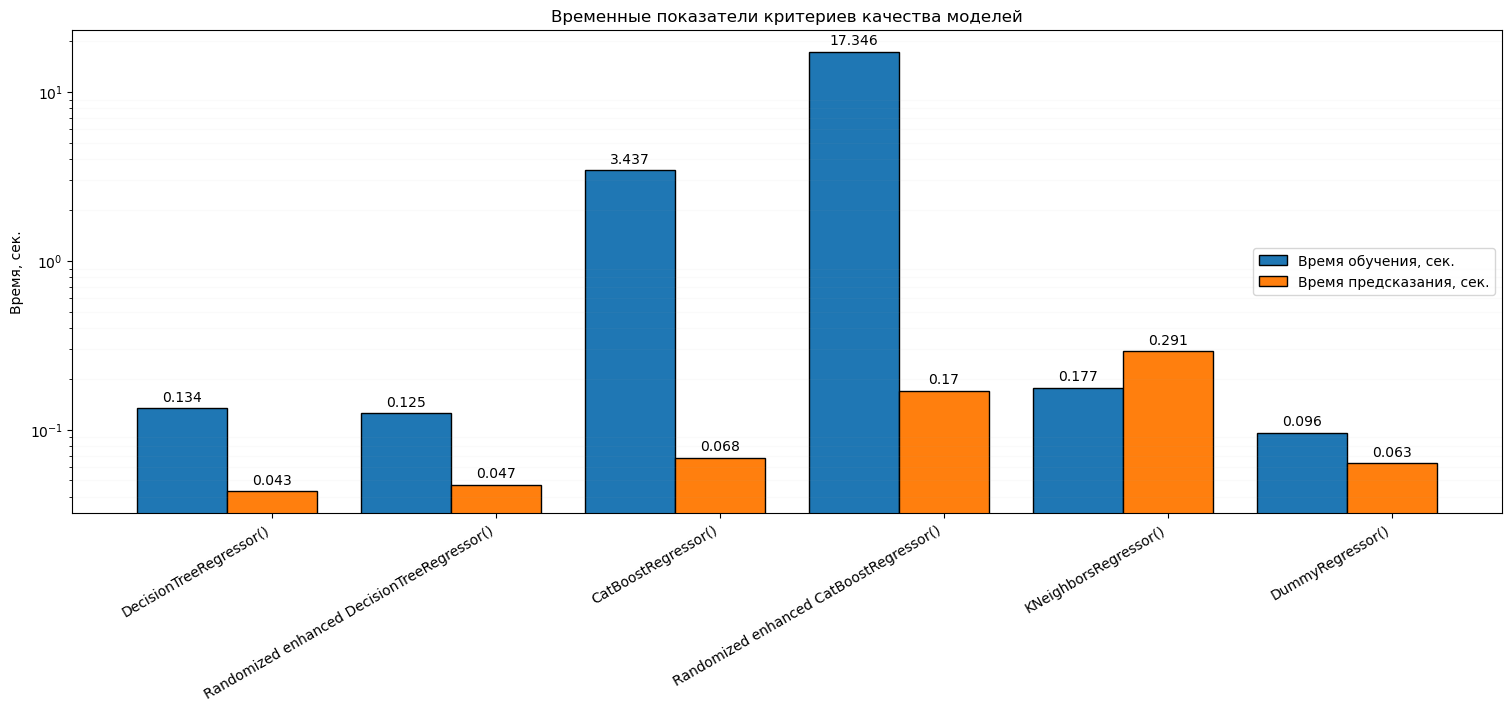

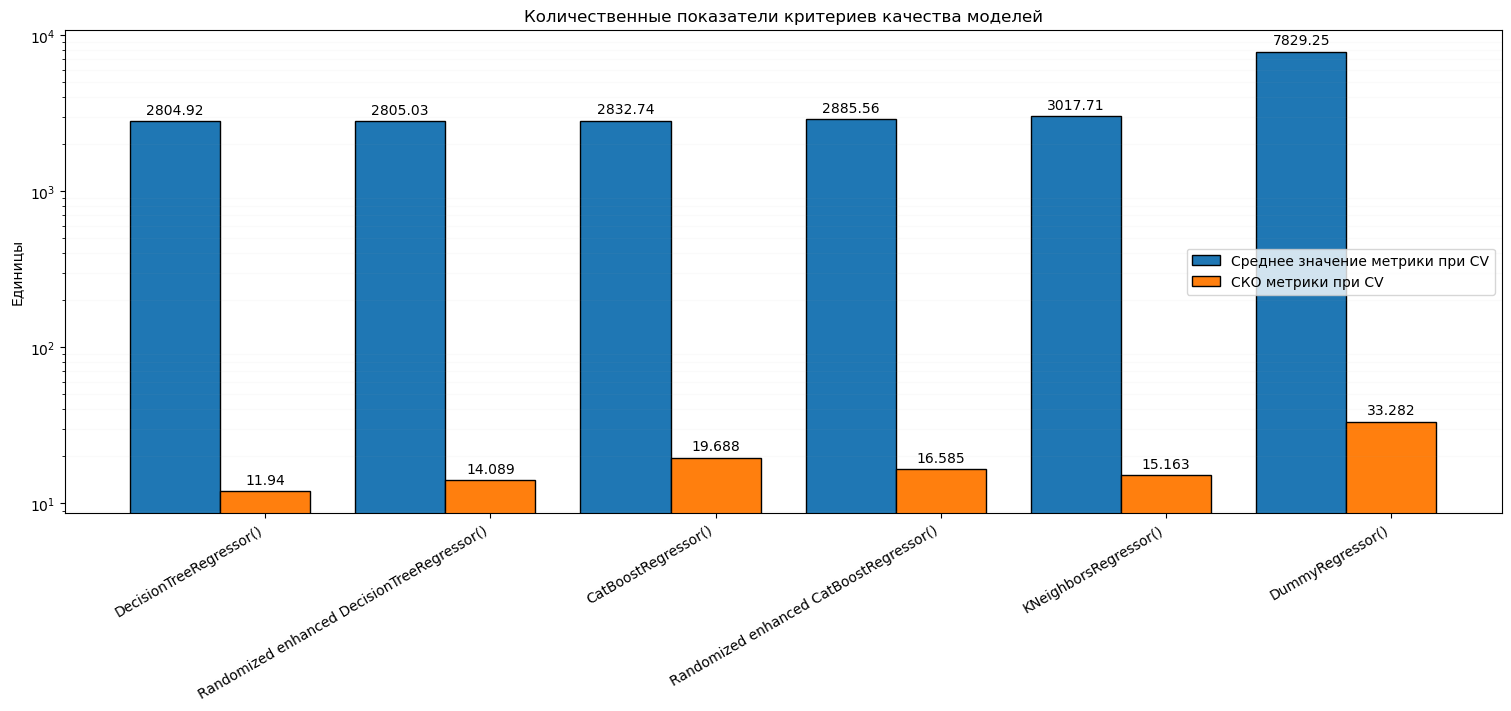

In [70]:
ticks = sorted_results['Наименование модели']
items = [
    sorted_results.iloc[:,1:3],
    sorted_results.iloc[:,3:]
]
texts = {
    'y_labels': [
        'Время, сек.',
        'Единицы'
    ],
    'titles': [
        'Временные показатели критериев качества моделей',
        'Количественные показатели критериев качества моделей'
    ],
}

for i in range(0,2):
    x = np.arange(len(ticks))
    width = 0.4
    multiplier = 0

    fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')

    for attribute, measurement in items[i].items():
        offset = width * multiplier
        rects = ax.bar(x + offset, 
                       measurement, 
                       width, 
                       label=attribute, 
                       log=True, 
                       edgecolor='black')
        ax.bar_label(rects, padding=3)
        multiplier += 1

    ax.set_ylabel(texts['y_labels'][i])
    ax.set_title(texts['titles'][i])
    ax.set_xticks(x + width, ticks, rotation=30, ha='right')
    ax.grid(visible=True, which='minor', alpha=0.05)
    ax.legend(loc='center right')
    plt.show()

#### Вывод по разделу "Оценка качества работы моделей: выбор лучшей модели" 

В результате анализа времени обучения, времени предсказания и качества моделей сделаны следующие выводы:
1. Модель DecisionTreeRegressor() без подбора гиперпараметров превзошла все другие модели по значению метрики.
2. Самая быстрая модель в обучении модель DecisionTreeRegressor() после подбора гиперпараметров.
3. Самая быстро предсказывающая модель - это снова DecisionTreeRegressor() после подбора гиперпараметров.
4. При этом, стабильность указанных моделей также лучшая.

In [71]:
sorted_results = results.df.sort_values(by='Среднее значение метрики при CV', 
                                        ascending=True)
sorted_results

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение метрики при CV,СКО метрики при CV
2,DecisionTreeRegressor(),0.134,0.043,2804.918,11.940
3,Randomized enhanced DecisionTreeRegressor(),0.125,0.047,2805.030,14.089
4,CatBoostRegressor(),3.437,0.068,2832.739,19.688
5,Randomized enhanced CatBoostRegressor(),17.346,0.170,2885.559,16.585
1,KNeighborsRegressor(),0.177,0.291,3017.714,15.163
0,DummyRegressor(),0.096,0.063,7829.249,33.282


**В связи с изложенным, лучшей моделью для заказчика признана DecisionTreeRegressor() после подбора гиперпараметров:**
1. Быстро обучается - около 0,1 секунды.
2. Быстро предсказывает - около 0.039 секунд.
3. Качественно предсказывает - RMSE составляет 2805.

Принятые ключевые параметры лучшей модели:

In [72]:
best_model = names['DecisionTreeRegressor()'].get_best_estimator('Randomized')

In [73]:
print(
    'Лучшая модель и её параметры:\n\n',
    best_model.steps[1][1]
)

Лучшая модель и её параметры:

 DecisionTreeRegressor(max_depth=18, max_features=18, random_state=1206)


## Оценка качества работы лучшей модели на тестовой выборке

### Предсказания выбранной лучшей модели на тестовой выборке и оценим её качество.

In [74]:
start_time = time.time()
y_pred = names['DecisionTreeRegressor()'].predict(X_test, 'Randomized')
time_pred_test = round(time.time() - start_time, 3)
score_RMSE_test = round(mean_squared_error(y_test, y_pred, squared=False), 3)
score_MAPE_test = round(mean_absolute_percentage_error(y_test, y_pred), 3)

print(f'Метрика RMSE лучшей модели на тестовой выборке:', score_RMSE_test)
print(f'Метрика MAPE лучшей модели на тестовой выборке:', score_MAPE_test)
print(f'Время предсказания лучшей модели на тестовой выборке:', time_pred_test)

Метрика RMSE лучшей модели на тестовой выборке: 2812.631
Метрика MAPE лучшей модели на тестовой выборке: 0.202
Время предсказания лучшей модели на тестовой выборке: 0.041


#### Вывод по разделу "Оценка качества работы лучшей модели на тестовой выборке" 

В результате выполненной работы:
1. Метрика RMSE для тестовых данных с использованием выбранной лучшей модели составила 2812.
2. Показатели метрик RMSE и MAPE отражают, что наша модели ошибается примерно на 2812 единиц (20%) при предсказании стоимости.
3. Скорость предсказания составила 0,036 секунд.
4. Используем созданную модели для анализа пользовательских данных.

## Оценка важности признаков, использованных для обучения.

Проведем анализ SHAP-значений.

In [75]:
explainer = shap.TreeExplainer(
    best_model.named_steps['decisiontreeregressor'], 
    feature_names=(
        best_model
        .named_steps['columntransformer']
        .get_feature_names_out()
    )
)
shap_values = explainer(
    best_model
    .named_steps['columntransformer']
    .transform(X_test)
)

Построим график общей значимости признаков. Столбчатая диаграмма отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. 

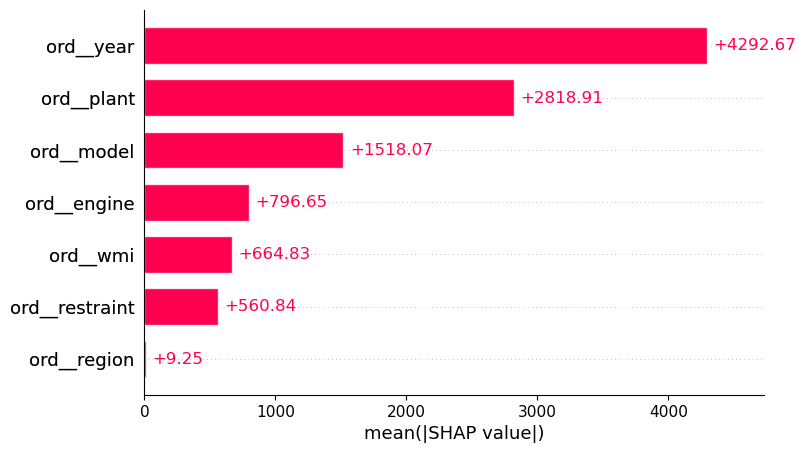

In [76]:
shap.plots.bar(shap_values, max_display=None) 

В соответствии с визуализацией влияния признаков на предсказание стоимости можно сделать следующие выводы в порядке снижения важности признаков:
- самый важный признак - год выпуска автомобиля. Очевидно, что формирование признака с указанием более точного года выпуска автомобиля увеличить качество модели МО;
- признак завода, на котором был выпущен автомобиль также играет важную роль в формировании стоимости автомобиля. Возможно, объем выпуска автомобилей играет важную роль - чем больше автомобилей выпускалось, тем больше данных для обучения. Кроме того, может репутация заводов играет роль;
- признак модели, характеристик двигателя также немаловажены. Целесообразно расширить данные для обучения подробной расшифровкой указанных признаков.
- World Manufacturer Identifier играет меньшую роль, поскольку представлены автомобили одного производителя. При этом регион выпуска не играет никакой роли.
- Также тип restraint системы играет минимальную роль в оценке стоимости.

### Обучение модели на отобранных признаках после оценки их важности.

В результате оценки важности признаков можно отметить, что ряд признаков вносят несущественный вклад в качество модели. Предлагается обучить лучшую модель на меньшем количестве признаков и полном датасете.

In [77]:
preprocessors[name], models[name]

([None], <catboost.core.CatBoostRegressor at 0x2101bf5ba90>)

In [78]:
cat_features_final = ['wmi', 'restraint', 'model', 'engine', 'year', 'plant']

In [79]:
preprocessor_final = ColumnTransformer(
    [
        ('ord', 
         ord_pipe, 
         cat_features_final)
    ],
    remainder='passthrough'
)

In [80]:
model_final = make_pipeline(preprocessor_final, DecisionTreeRegressor(max_depth=18, max_features=18, random_state=1206))

In [81]:
X.head()

,wmi,restraint,model,engine,year,plant,region
0,2FM,D,K3J,C,B,B,Canada
1,3FA,6,P0H,7,E,R,Mexico
2,3FA,H,P08,Z,7,R,Mexico
3,1FM,C,U0G,X,D,U,United States
4,1FA,H,P2E,8,D,G,United States


In [82]:
X_final = X.drop('region', axis=1)

In [83]:
model_final.fit(X_final, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['wmi', 'restraint', 'model',
                                                   'engine', 'year',
                                                   'plant'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_depth=18, max_features=18,
                                       random_state=1206))])

## Разработка интефейса взаимодействия клиентов и модели.

Сохраним модель для дальнейшего использования

In [84]:
import joblib

In [85]:
joblib.dump(model_final, "model.joblib")

['model.joblib']

Исходные данные с описаниями автомобилей

In [86]:
ford_wmi = {
    'AFA': 'Ford Motor Company of Southern Africa & Samcor',
    'AFB': 'Mazda BT-50 made by Ford Motor Company of Southern Africa',
    'JC0': 'Ford brand cars made by Mazda',
    'JC2': 'Ford Courier made by Mazda',
    'KNJ': 'Ford Festiva & Aspire made by Kia',
    'LJX': 'JMC Ford',
    'LVS': 'Changan Ford & Changan Ford Mazda',
    'MAJ': 'Ford India',
    'MNB': 'Ford Thailand',
    'NM0': 'Ford Otosan',
    'PE1': 'Ford Motor Company Philippines',
    'PE3': 'Mazda Philippines made by Ford Motor Company Philippines',
    'PR8': 'Ford',
    'LFA': 'Ford Lio Ho Motor Co Ltd. old designation',
    'RHA': 'Ford Lio Ho Motor Co Ltd. new designation',
    'RL0': 'Ford Vietnam',
    'SBC': 'Iveco Ford Truck',
    'SFA': 'Ford UK',
    'VSK': 'Nissan Motor Iberica SA, Nissan passenger car/MPV/van/SUV/pickup & Ford Maverick 1993–1999',
    'VS6': 'Ford Spain',
    'WF0': 'Ford Germany',
    'X9F': 'Ford Motor Company ZAO',
    'Z6F': 'Ford Sollers (Russia)',
    '1FA': 'Ford car',
    '1FB': 'Ford "bus" (van with more than 3 rows of seats)',
    '1FC': 'Ford stripped chassis made by Ford',
    '1FD': 'Ford incomplete vehicle',
    '1FM': 'Ford MPV/SUV',
    '1FT': 'Ford truck',
    '1F1': 'Ford SUV - Limousine (through 2009)',
    '1F6': 'Ford stripped chassis made by Detroit Chassis LLC',
    '1ZV': 'Ford made by AutoAlliance International',
    '2FA': 'Ford car',
    '2FM': 'Ford MPV/SUV',
    '2FT': 'Ford truck',
    '3FA': 'Ford car',
    '3FC': 'Ford stripped chassis made by Ford & IMMSA',
    '3FE': 'Ford Mexico',
    '3FM': 'Ford MPV/SUV',
    '3FN': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (truck)',
    '3FR': 'Ford F-650/F-750 made by Blue Diamond Truck Co. (incomplete vehicle)',
    '3FT': 'Ford truck',
    '4F2': 'Mazda SUV made by Ford',
    '4F4': 'Mazda truck made by Ford',
    '4N2': 'Nissan Quest made by Ford',
    '5LD': 'Ford & Lincoln incomplete vehicle – limousine (2010–2014)',
    '6F1': 'Ford',
    '6FP': 'Ford Australia',
    '7A5': 'Ford New Zealand',
    '8AF': 'Ford Argentina',
    '9BF': 'Ford Brazil',
}

In [87]:
models = {
    'A11': 'Ford Aerostar regular length passenger van (86-97)',
    'A14': 'Ford Aerostar regular length cargo van (86-97)',
    'A15': 'Ford Aerostar regular length cargo van w/side windows (86-94)',
    'A21': 'Ford Aerostar regular length passenger van 4WD (90-94)',
    'A24': 'Ford Aerostar regular length cargo van 4WD (90-94)',
    'A25': 'Ford Aerostar regular length cargo van w/side windows 4WD (90-94)',
    'A31': 'Ford Aerostar extended length passenger van (89-97)',
    'A34': 'Ford Aerostar extended length cargo van (89-94)',
    'A35': 'Ford Aerostar extended length cargo van w/side windows (89-94)',
    'A41': 'Ford Aerostar extended length passenger van 4WD (90-97)',
    'A44': 'Ford Aerostar extended length cargo van 4WD (90-94)',
    'A45': 'Ford Aerostar extended length cargo van w/side windows 4WD (90-94)',
    'A51': 'Ford Windstar passenger van (95-98)',
    'A50': 'Ford Windstar Base model (00), LX 3-door (01), LX Base (02), Base model (03)',
    'A51': 'Ford Windstar LX (99-00), LX 4-door (01), LX Standard, LX Deluxe (02-03)',
    'A52': 'Ford Windstar SE (99-03)',
    'A53': 'Ford Windstar SEL (99-03), Limited (00)',
    'A54': 'Ford Windstar cargo van (95-03)',
    'A57': 'Ford Windstar SE Sport (01)',
    'A58': 'Ford Windstar Limited (01-03)',
    'A50': 'Ford Freestar S (04-05)',
    'A51': 'Ford Freestar SE (04-07)',
    'A52': 'Ford Freestar SEL (04-07)',
    'A54': 'Ford Freestar cargo van (04-07)',
    'A57': 'Ford Freestar SES (04-05)',
    'A58': 'Ford Freestar Limited (04-07)',
    'A20': 'Mercury Monterey (04)',
    'A21': 'Mercury Monterey; Convenience (05)',
    'A22': 'Mercury Monterey; Luxury (05-07)',
    'A23': 'Mercury Monterey; Premier (05)',
    'C35': 'Ford E-350 Chassis Cab (03-04)',
    'C45': 'Ford E-450 Chassis Cab (03-04)',
    'C55': 'Ford E-550 Chassis Cab (03)',
    'E01': 'Ford Econoline, Club Wagon E-100 regular length (81-82)',
    'E04': 'Ford Econoline, E-100 Cargo Van regular length (81-83)',
    'E05': 'Ford Econoline, E-100 Window Van regular length (81-83)',
    'E06': 'Ford Econoline, E-100 Display Van regular length (81-83)',
    'E11': 'Ford Econoline, Club Wagon E-150 regular length (81-91)',
    'E14': 'Ford Econoline, E-150 Cargo Van regular length (81-91)',
    'E15': 'Ford Econoline, E-150 Window Van regular length (81-87)',
    'E16': 'Ford Econoline, E-150 Display Van regular length (81-85)',
    'E21': 'Ford Econoline, Club Wagon E-250 regular length (81-91)',
    'E24': 'Ford Econoline, E-250 Cargo Van regular length (81-91)',
    'E25': 'Ford Econoline, E-250 Window Van regular length (81-87)',
    'E25': 'Ford Econoline, E-250HD Cargo Van regular length (91)',
    'E26': 'Ford Econoline, E-250 Display Van regular length (81-85)',
    'E30': 'Ford Econoline, E-350 RV cutaway (81-91)',
    'E33': 'Ford Econoline, E-350 RV stripped chassis (85-91)',
    'E34': 'Ford Econoline, E-350 Cargo Van regular length (81-91)',
    'E35': 'Ford Econoline, E-350 Window Van regular length (81-87)',
    'E36': 'Ford Econoline, E-350 Display Van regular length (81-85)',
    'E37': 'Ford Econoline, E-350 Commercial cutaway (81-91)',
    'E38': 'Ford Econoline, E-350 Cutaway w/Parcel Delivery Van (81-84)',
    'E39': 'Ford Econoline, E-350 Commercial stripped chassis (81-91)',
    'E11': 'Ford E-Series, E-150 wagon regular length (92-09)',
    'E14': 'Ford E-Series, E-150 van regular length (92-09)',
    'E24': 'Ford E-Series, E-250 van regular length (92-09)',
    'E25': 'Ford E-Series, E-250 Super Duty cutaway (07-09)',
    'E27': 'Ford E-Series, E-250 (Super Duty) Commercial cutaway (94-99)',
    'E29': 'Ford E-Series, E-250 (Super Duty) Commercial stripped chassis (94-03)',
    'E30': 'Ford E-Series, E-350 (Super Duty) RV cutaway (92-99)',
    'E31': 'Ford E-Series, E-350 (Super Duty) wagon regular length (92-09)',
    'E33': 'Ford E-Series, E-350 (Super Duty) RV stripped chassis (92-93)',
    'E34': 'Ford E-Series, E-350 (Super Duty) van regular length (92-09)',
    'E35': 'Ford E-Series, E-350 Super Duty cutaway (00-09)',
    'E37': 'Ford E-Series, E-350 (Super Duty) Commercial cutaway (92-99)',
    'E39': 'Ford E-Series, E-350 (Super Duty) Commercial stripped chassis (92-09)',
    'E40': 'Ford E-Series, E-Super Duty RV cutaway (96-98), E-450 Super Duty RV cutaway (99)',
    'E45': 'Ford E-Series, E-450 Super Duty cutaway (00-09)',
    'E47': 'Ford E-Series, E-Super Duty Commercial cutaway (96-98), E-450 Super Duty Commercial cutaway (99)',
    'E49': 'Ford E-Series, E-450 Super Duty stripped chassis (00-09)',
    'E55': 'Ford E-Series, E-550 Super Duty cutaway (02-03)',
    'E1B': 'Ford E-Series, E-150 wagon regular length (10-14)',
    'E1E': 'Ford E-Series, E-150 van regular length (10-14)',
    'E2E': 'Ford E-Series, E-250 van regular length (10-14)',
    'E2F': 'Ford E-Series, E-250 Super Duty cutaway (10-12)',
    'E3B': 'Ford E-Series, E-350 Super Duty wagon regular length (10-14)',
    'E3E': 'Ford E-Series, E-350 Super Duty van regular length (10-14)',
    'E3F': 'Ford E-Series, E-350 Super Duty cutaway (10-)',
    'E3K': 'Ford E-Series, E-350 Super Duty stripped chassis (10-)',
    'E4F': 'Ford E-Series, E-450 Super Duty cutaway (10-)',
    'E4K': 'Ford E-Series, E-450 Super Duty stripped chassis (10-)',
    'E1Y': 'Ford Transit 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (15-19)',
    'E1Z': 'Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase (15-19)',
    'E2Y': 'Ford Transit 150, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'E9Z': 'Ford Transit 150, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase (15-19)',
    'E1C': 'Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (15-19)',
    'E1D': 'Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase (16-19)',
    'E2C': 'Ford Transit 150, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'E2D': 'Ford Transit 150, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase (16-19)',
    'E1Y': 'Ford Transit 150, Cargo Van, Low Roof, RWD (20-)',
    'E2Y': 'Ford Transit 150, Cargo Van, Low Roof, AWD (20-)',
    'E1Z': 'Ford Transit 150, Crew Van, Low Roof, RWD (20-23)',
    'E9Z': 'Ford Transit 150, Crew Van, Low Roof, AWD (20-23)',
    'E1C': 'Ford Transit 150, Cargo Van, Medium Roof, RWD (20-)',
    'E2C': 'Ford Transit 150, Cargo Van, Medium Roof, AWD (20-)',
    'E1D': 'Ford Transit 150, Crew Van, Medium Roof, RWD (20-23)',
    'E2D': 'Ford Transit 150, Crew Van, Medium Roof, AWD (20-23)',
    'E5A': 'Ford Bronco; 2-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks (21-23)',
    'E5B': 'Ford Bronco; 4-door; 4x4; Base model, Big Bend, Black Diamond, Outer Banks (21-23)',
    'E5C': 'Ford Bronco; 2-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak (21-23)',
    'E5D': 'Ford Bronco; 4-door; Advanced 4x4; Base model, Big Bend, Black Diamond, Outer Banks, Badlands, Wildtrak (21-23), Everglades (22-23)',
    'E5E': 'Ford Bronco; 4-door; Advanced 4x4; First Edition (21)',
    'E5F': 'Ford Bronco; 2-door; Advanced 4x4; First Edition (21)',
    'E5J': 'Ford Bronco; 4-door; Advanced 4x4; Raptor (22-23)',
    'E4C': 'Ford Bronco; 2-door; Heritage Edition (23-)',
    'E4D': 'Ford Bronco; 4-door; Heritage Edition (23-)',
    'E4E': 'Ford Bronco; 2-door; Heritage Limited Edition (23-)',
    'E4G': 'Ford Bronco; 4-door; Heritage Limited Edition (23-)',
    'E0R': 'Ford Bronco; 4-door; Raptor (24-)',
    'E1A': 'Ford Bronco; 2-door; Black Diamond (24-)',
    'E1B': 'Ford Bronco; 4-door; Black Diamond (24-)',
    'E2A': 'Ford Bronco; 2-door; Wildtrak (24-)',
    'E2B': 'Ford Bronco; 4-door; Wildtrak (24-)',
    'E4H': 'Ford Bronco; 4-door; Everglades (24-)',
    'E7A': 'Ford Bronco; 2-door; Big Bend (24-)',
    'E7B': 'Ford Bronco; 4-door; Big Bend (24-)',
    'E8B': 'Ford Bronco; 4-door; Outer Banks (24-)',
    'E9A': 'Ford Bronco; 2-door; Badlands (24-)',
    'E9B': 'Ford Bronco; 4-door; Badlands (24-)',
    'E6E': 'Ford Transit Connect; XL Cargo Van SWB w/Rear Liftgate (14-21)',
    'E6F': 'Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate (14-21)',
    'E6S': 'Ford Transit Connect; XL Cargo Van SWB w/Rear Liftgate (22-23)',
    'E6T': 'Ford Transit Connect; XLT Cargo Van SWB w/Rear Liftgate (22-23)',
    'E7E': 'Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate (14-21)',
    'E7F': 'Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate (14-21)',
    'E7S': 'Ford Transit Connect; XL Cargo Van LWB w/Rear Liftgate (22-23)',
    'E7T': 'Ford Transit Connect; XLT Cargo Van LWB w/Rear Liftgate (22-23)',
    'E8F': 'Ford Transit Connect; XLT Wagon SWB w/Rear Liftgate (14-18)',
    'E8G': 'Ford Transit Connect; Titanium Wagon SWB w/Rear Liftgate (17-18)',
    'E9E': 'Ford Transit Connect; XL Wagon LWB w/Rear Liftgate (14-23)',
    'E9F': 'Ford Transit Connect; XLT Wagon LWB w/Rear Liftgate (14-23)',
    'E9G': 'Ford Transit Connect; Titanium Wagon LWB w/Rear Liftgate (14-23)',
    'F10': 'Ford F-Series, F-100, Regular Cab, 2WD (81-83)',
    'F14': 'Ford F-Series, F-150, Regular Cab, 4WD (81-96)',
    'F15': 'Ford F-Series, F-150, Regular Cab, 2WD (81-96)',
    'F25': 'Ford F-Series, F-250, Regular Cab, 2WD (81-97)',
    'F26': 'Ford F-Series, F-250, Regular Cab, 4WD (81-97)',
    'F27': 'Ford F-Series, F-250, Regular Cab, 2WD, Chassis Cab (81-85)',
    'F28': 'Ford F-Series, F-250, Regular Cab, 4WD, Chassis Cab (81-84)',
    'F35': 'Ford F-Series, F-350, Regular Cab, 2WD (81-97)',
    'F36': 'Ford F-Series, F-350, Regular Cab, 4WD (81-97)',
    'F37': 'Ford F-Series, F-350, Regular Cab, 2WD, Chassis Cab (81-97)',
    'F38': 'Ford F-Series, F-350, Regular Cab, 4WD, Chassis Cab (81-97)',
    'F47': 'Ford F-Series, F-Super Duty, Regular Cab, 2WD, Chassis Cab (88-97)',
    'F07': 'Ford F-Series, F-150, Regular Cab, Flareside, 2WD (97-03)',
    'F08': 'Ford F-Series, F-150, Regular Cab, Flareside, 4WD (97-03)',
    'F17': 'Ford F-Series, F-150, Regular Cab, Styleside, 2WD (97-03)',
    'F18': 'Ford F-Series, F-150, Regular Cab, Styleside, 4WD (97-03)',
    'F07': 'Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 2WD (04)',
    'F08': 'Ford F-Series, F-150 Heritage, Regular Cab, Flareside, 4WD (04)',
    'F17': 'Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 2WD (04)',
    'F18': 'Ford F-Series, F-150 Heritage, Regular Cab, Styleside, 4WD (04)',
    'F27': 'Ford F-Series, F-250, Regular Cab, Styleside, 2WD (97-99)',
    'F28': 'Ford F-Series, F-250, Regular Cab, Styleside, 4WD (97-99)',
    'F02': 'Ford F-Series, F-150, Regular Cab, Flareside, 2WD (04-09)',
    'F04': 'Ford F-Series, F-150, Regular Cab, Flareside, 4WD (04-09)',
    'F12': 'Ford F-Series, F-150, Regular Cab, Styleside, 2WD (04-09)',
    'F14': 'Ford F-Series, F-150, Regular Cab, Styleside, 4WD (04-09)',
    'F1C': 'Ford F-Series, F-150, Regular Cab, Styleside, 2WD (10-23)',
    'F1E': 'Ford F-Series, F-150, Regular Cab, Styleside, 4WD (10-23)',
    'F1K': 'Ford F-Series, F-150, Regular Cab, 2WD; XL (24-)',
    'F1L': 'Ford F-Series, F-150, Regular Cab, 4WD; XL (24-)',
    'F20': 'Ford F-Series, Super Duty F-250, Regular Cab, 2WD (99-09)',
    'F21': 'Ford F-Series, Super Duty F-250, Regular Cab, 4WD (99-09)',
    'F30': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels (99-09)',
    'F31': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels (99-09)',
    'F32': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels (99-09)',
    'F33': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels (99-09)',
    'F34': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels (99-09)',
    'F35': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels (99-09)',
    'F36': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F37': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F46': 'Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F47': 'Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F56': 'Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F57': 'Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'F2A': 'Ford F-Series, Super Duty F-250, Regular Cab, 2WD (10-)',
    'F2B': 'Ford F-Series, Super Duty F-250, Regular Cab, 4WD (10-)',
    'F3A': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Single Rear Wheels (10-)',
    'F3B': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Single Rear Wheels (10-)',
    'F3C': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Dual Rear Wheels (10-)',
    'F3D': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Dual Rear Wheels (10-)',
    'F3E': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Single Rear Wheels (10-)',
    'F3F': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Single Rear Wheels (10-)',
    'F3G': 'Ford F-Series, Super Duty F-350, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F3H': 'Ford F-Series, Super Duty F-350, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F4C': 'Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Dual Rear Wheels (19-)',
    'F4D': 'Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Dual Rear Wheels (19-)',
    'F4G': 'Ford F-Series, Super Duty F-450, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F4H': 'Ford F-Series, Super Duty F-450, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F5G': 'Ford F-Series, Super Duty F-550, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F5H': 'Ford F-Series, Super Duty F-550, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'F6K': 'Ford F-Series, Super Duty F-600, Regular Cab, 2WD, Chassis Cab, Dual Rear Wheels (20-)',
    'F6L': 'Ford F-Series, Super Duty F-600, Regular Cab, 4WD, Chassis Cab, Dual Rear Wheels (20-)',
    'F4X': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length (15-19)',
    'F4U': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length (16-19)',
    'F6P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F6Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F8P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F8Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F9P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F9Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 9,950 lb. GVWR (15-19)',
    'F1Y': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, RWD (23-)',
    'F2Y': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Low Roof, Long (148 in.) wheelbase, AWD (23-)',
    'F1P': 'Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR (23-)',
    'F1Z': 'Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR (23-)',
    'F2P': 'Ford Transit 350 HD, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR (23-)',
    'F2Z': 'Ford Transit 350 HD, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR (23-)',
    'F7C': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, RWD (23-)',
    'F8C': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, Medium Roof, Long (148 in.) wheelbase, AWD (23-)',
    'F5X': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD (23-)',
    'F6X': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD (23-)',
    'F7X': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD (23-)',
    'F8X': 'Ford Transit 350 HD, Single Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD (23-)',
    'F4X': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR (20-)',
    'F4U': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR (20-)',
    'F4V': 'Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 9,950 lb. GVWR (20-23)',
    'F4W': 'Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 9,950 lb. GVWR (20-23)',
    'F6P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 9,950 lb. GVWR (20-)',
    'F6Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 9,950 lb. GVWR (20-)',
    'F8P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 9,950 lb. GVWR (20-)',
    'F8Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 9,950 lb. GVWR (20-)',
    'J1A': 'Lincoln MKC; FWD (15)',
    'J1B': 'Lincoln MKC Black Label; AWD (15)',
    'J2A': 'Lincoln MKC; AWD (15)',
    'J2B': 'Lincoln MKC Black Label; FWD (15)',
    'J1C': 'Lincoln MKC; Premiere FWD (16-18), Base model FWD (19)',
    'J1D': 'Lincoln MKC; Premiere AWD (16-18), Base model AWD (19)',
    'J2C': 'Lincoln MKC; Select FWD (16-19)',
    'J2D': 'Lincoln MKC; Select AWD (16-19)',
    'J3C': 'Lincoln MKC; Reserve FWD (16-19)',
    'J3D': 'Lincoln MKC; Reserve AWD (16-19)',
    'J4C': 'Lincoln MKC Black Label; FWD (16-19)',
    'J4D': 'Lincoln MKC Black Label; AWD (16-19)',
    'J1C': 'Lincoln Corsair; Base model FWD (20-)',
    'J1D': 'Lincoln Corsair; Base model AWD (20-)',
    'J2C': 'Lincoln Corsair; Reserve FWD (20-)',
    'J2D': 'Lincoln Corsair; Reserve AWD (20-)',
    'J5D': 'Lincoln Corsair; Grand Touring AWD (21-)',
    'J2H': 'Lincoln Navigator; 4x2 (10-15)',
    'J2J': 'Lincoln Navigator; 4x4 (10-15)',
    'J3H': 'Lincoln Navigator L; 4x2 (10-15)',
    'J3J': 'Lincoln Navigator L; 4x4 (10-15)',
    'J2H': 'Lincoln Navigator; Select 4x2 (16-17)',
    'J2J': 'Lincoln Navigator; Select 4x4 (16-17)',
    'J2K': 'Lincoln Navigator; Reserve 4x2 (16-17)',
    'J2L': 'Lincoln Navigator; Reserve 4x4 (16-17)',
    'J3H': 'Lincoln Navigator L; Select 4x2 (16-17)',
    'J3J': 'Lincoln Navigator L; Select 4x4 (16-17)',
    'J3K': 'Lincoln Navigator L; Reserve 4x2 (16-17)',
    'J3L': 'Lincoln Navigator L; Reserve 4x4 (16-17)',
    'J2H': 'Lincoln Navigator; Select 4x2 (18-19)',
    'J2J': 'Lincoln Navigator; Select 4x4 (18-19)',
    'J2K': 'Lincoln Navigator; Reserve 4x2 (20-23)',
    'J2L': 'Lincoln Navigator; Reserve 4x4 (18-)',
    'J2M': 'Lincoln Navigator; Premiere 4x2 (18), Base model 4x2 (19-23)',
    'J2N': 'Lincoln Navigator; Premiere 4x4 (18), Base model 4x4 (19-)',
    'J2T': 'Lincoln Navigator; Black Label 4x4 (18-)',
    'J3H': 'Lincoln Navigator L; Select 4x2 (18-19)',
    'J3J': 'Lincoln Navigator L; Select 4x4 (18-19)',
    'J3K': 'Lincoln Navigator L; Reserve 4x2 (20-23)',
    'J3L': 'Lincoln Navigator L; Reserve 4x4 (18-)',
    'J3M': 'Lincoln Navigator L; Base model 4x2 (20-23)',
    'J3N': 'Lincoln Navigator L; Base model 4x4 (20-)',
    'J3T': 'Lincoln Navigator L; Black Label 4x4 (18-)',
    'J5A': 'Lincoln MKT; AWD (10-19)',
    'J5F': 'Lincoln MKT; FWD (10-18)',
    'J5L': 'Lincoln MKT Town Car; Hearse/Limo, AWD (12-19)',
    'J5M': 'Lincoln MKT Town Car; Livery, FWD (13-17)',
    'J5N': 'Lincoln MKT Town Car; Livery, AWD (13-19)',
    'J6J': 'Lincoln MKX FWD (10-15)',
    'J8J': 'Lincoln MKX AWD (10-15)',
    'J6J': 'Lincoln MKX Premiere FWD (16-18)',
    'J8J': 'Lincoln MKX Premiere AWD (16-18)',
    'J6K': 'Lincoln MKX Select FWD (16-18)',
    'J8K': 'Lincoln MKX Select AWD (16-18)',
    'J6L': 'Lincoln MKX Reserve FWD (16-18)',
    'J8L': 'Lincoln MKX Reserve AWD (16-18)',
    'J7J': 'Lincoln MKX Black Label FWD (16-18)',
    'J9J': 'Lincoln MKX Black Label AWD (16-18)',
    'J6J': 'Lincoln Nautilus Base model FWD (19-23)',
    'J8J': 'Lincoln Nautilus Base model AWD (19-23)',
    'J6K': 'Lincoln Nautilus Select FWD (19)',
    'J8K': 'Lincoln Nautilus Select AWD (19)',
    'J6L': 'Lincoln Nautilus Reserve FWD (19-23)',
    'J8L': 'Lincoln Nautilus Reserve AWD (19-23)',
    'J7J': 'Lincoln Nautilus Black Label FWD (19)',
    'J9J': 'Lincoln Nautilus Black Label AWD (19-23)',
    'J6W': 'Lincoln Aviator; Base model, RWD (20-)',
    'J6X': 'Lincoln Aviator; Base model, AWD (20-)',
    'J7W': 'Lincoln Aviator; Reserve, RWD (20-)',
    'J7X': 'Lincoln Aviator; Reserve, AWD (20-)',
    'J8X': 'Lincoln Aviator; Grand Touring, AWD (20-23)',
    'J9X': 'Lincoln Aviator; Black Label, AWD (20-)',
    'J9Y': 'Lincoln Aviator; Black Label Grand Touring, AWD (20-23)',
    'J0W': 'Lincoln Aviator; Livery, RWD (21-)',
    'J0X': 'Lincoln Aviator; Livery, AWD (21-)',
    'K01': 'Ford Freestyle; SE, FWD (05-06)',
    'K02': 'Ford Freestyle (05-07)/Ford Taurus X (08-09); SEL, FWD',
    'K03': 'Ford Freestyle (05-07)/Taurus X (08-09); Limited, FWD',
    'K04': 'Ford Freestyle; SE, AWD (05-06)',
    'K05': 'Ford Freestyle (05-07)/Taurus X (08-09); SEL, AWD',
    'K06': 'Ford Freestyle (05-07)/Taurus X (08-09); Limited, AWD',
    'K07': 'Ford Taurus X; Eddie Bauer, FWD (08-09)',
    'K08': 'Ford Taurus X; Eddie Bauer, AWD (08-09)',
    'K15': 'Ford Expedition EL; 4x2, XLT (07-09)',
    'K16': 'Ford Expedition EL; 4x4, XLT (07-09)',
    'K17': 'Ford Expedition EL; 4x2, Eddie Bauer (07-09), King Ranch (08-09)',
    'K18': 'Ford Expedition EL; 4x4, Eddie Bauer (07-09), King Ranch (08-09)',
    'K19': 'Ford Expedition EL; 4x2, Limited (07-09)',
    'K20': 'Ford Expedition EL; 4x4, Limited (07-09)',
    'K1F': 'Ford Expedition EL; 4x2, XLT (10), XL (11-17)',
    'K1G': 'Ford Expedition EL; 4x4, XLT (10), XL (11-17)',
    'K1H': 'Ford Expedition EL; 4x2, Eddie Bauer (10), XLT (11-17), King Ranch (10-17)',
    'K1J': 'Ford Expedition EL; 4x4, Eddie Bauer (10), XLT (11-17), King Ranch (10-17)',
    'K1K': 'Ford Expedition EL; 4x2, Limited (10-17)',
    'K1L': 'Ford Expedition EL; 4x2, Platinum (15-17)',
    'K1M': 'Ford Expedition EL; 4x4, Platinum (15-17)',
    'K2A': 'Ford Expedition EL; 4x4, Limited (10-17)',
    'K1F': 'Ford Expedition Max; 4x2, XL (18-)',
    'K1G': 'Ford Expedition Max; 4x4, XL (18-)',
    'K1H': 'Ford Expedition Max; 4x2, XLT (18-)',
    'K1J': 'Ford Expedition Max; 4x4, XLT (18-)',
    'K1K': 'Ford Expedition Max; 4x2, Limited (18-)',
    'K1L': 'Ford Expedition Max; 4x2, Platinum (18-)',
    'K1M': 'Ford Expedition Max; 4x4, Platinum (18-)',
    'K1N': 'Ford Expedition Max; 4x2, King Ranch (20-)',
    'K1P': 'Ford Expedition Max; 4x4, King Ranch (20-)',
    'K2A': 'Ford Expedition Max; 4x4, Limited (18-)',
    'K1R': 'Ford Mustang Mach-E; RWD, Select (21-)',
    'K1S': 'Ford Mustang Mach-E; AWD, Select (21-)',
    'K2R': 'Ford Mustang Mach-E; RWD, California Route 1 (21-22)',
    'K2S': 'Ford Mustang Mach-E; AWD, California Route 1 (22-23)',
    'K3R': 'Ford Mustang Mach-E; RWD, Premium (21-)',
    'K3S': 'Ford Mustang Mach-E; AWD, Premium (21-), First Edition (21)',
    'K4S': 'Ford Mustang Mach-E; AWD, GT (21-)',
    'K1Y': 'Ford Transit 150, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door (15-19)',
    'K1Z': 'Ford Transit 150, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors (15-19)',
    'K1C': 'Ford Transit 150, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door (15-19)',
    'K1Y': 'Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, RWD (20-22)',
    'K2Y': 'Ford Transit 150, Passenger Van, Low Roof, Regular (130 in.) wheelbase, AWD (20-22)',
    'K1C': 'Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, RWD (20-22)',
    'K2C': 'Ford Transit 150, Passenger Van, Medium Roof, Regular (130 in.) wheelbase, AWD (20-22)',
    'K30': 'Ford Edge; Sport FWD (09)',
    'K36': 'Ford Edge; SE FWD (07-09)',
    'K38': 'Ford Edge; SEL FWD (07-09)',
    'K39': 'Ford Edge; SEL Plus FWD (07), Limited FWD (08-09)',
    'K40': 'Ford Edge; Sport AWD (09)',
    'K46': 'Ford Edge; SE AWD (07-09)',
    'K48': 'Ford Edge; SEL AWD (07-09)',
    'K49': 'Ford Edge; SEL Plus AWD (07), Limited AWD (08-09)',
    'K3A': 'Ford Edge; Sport FWD (10-15)',
    'K3G': 'Ford Edge; SE FWD (10-21)',
    'K3J': 'Ford Edge; SEL FWD (10-21), ST-Line FWD (20-21)',
    'K3K': 'Ford Edge; Limited FWD (10-14), Titanium FWD (15-21)',
    'K4A': 'Ford Edge; Sport AWD (10-18), ST AWD (19-24)',
    'K4G': 'Ford Edge; SE AWD (10-24)',
    'K4J': 'Ford Edge; SEL AWD (10-24), ST-Line AWD (20-24)',
    'K4K': 'Ford Edge; Limited AWD (10-14), Titanium AWD (15-24)',
    'K51': 'Ford Flex; SE, FWD (09)',
    'K52': 'Ford Flex; SEL, FWD (09)',
    'K53': 'Ford Flex; Limited, FWD (09)',
    'K62': 'Ford Flex; SEL, AWD (09)',
    'K63': 'Ford Flex; Limited, AWD (09)',
    'K5B': 'Ford Flex; SE FWD (10-19)',
    'K5C': 'Ford Flex; SEL FWD (10-19)',
    'K5D': 'Ford Flex; Limited FWD (10-19), Titanium FWD (11-12)',
    'K6C': 'Ford Flex; SEL AWD (10-19)',
    'K6D': 'Ford Flex; Limited AWD (10-19), Titanium AWD (11-12)',
    'K7A': 'Ford Explorer; Police Interceptor Utility, FWD (13)',
    'K7B': 'Ford Explorer; Base model, FWD (11-19)',
    'K7D': 'Ford Explorer; XLT, FWD (11-19)',
    'K7F': 'Ford Explorer; Limited, FWD (11-19)',
    'K8A': 'Ford Explorer; Police Interceptor Utility, AWD (13-19)',
    'K8B': 'Ford Explorer; Base model, AWD (11-19)',
    'K8D': 'Ford Explorer; XLT, AWD (11-19)',
    'K8F': 'Ford Explorer; Limited, AWD (11-19)',
    'K8G': 'Ford Explorer; Sport, AWD (13-19)',
    'K8H': 'Ford Explorer; Platinum, AWD (16-19)',
    'K7B': 'Ford Explorer; Base model, RWD (20-)',
    'K7D': 'Ford Explorer; XLT, RWD (20-)',
    'K7F': 'Ford Explorer; Limited, RWD (20-)',
    'K7G': 'Ford Explorer; ST, RWD (22-)',
    'K7H': 'Ford Explorer; Platinum, RWD (21-)',
    'K7K': 'Ford Explorer; ST-Line, RWD (22-)',
    'K7L': 'Ford Explorer; King Ranch, RWD (21-)',
    'K8A': 'Ford Explorer; Police Interceptor Utility, AWD (20-)',
    'K8B': 'Ford Explorer; Base model, AWD (20-)',
    'K8D': 'Ford Explorer; XLT, AWD (20-)',
    'K8F': 'Ford Explorer; Limited, AWD (20-)',
    'K8G': 'Ford Explorer; ST, AWD (20-)',
    'K8H': 'Ford Explorer; Platinum, AWD (20-)',
    'K8J': 'Ford Explorer; Timberline, AWD (21-)',
    'K8K': 'Ford Explorer; ST-Line, AWD (22-)',
    'K8L': 'Ford Explorer; King Ranch, AWD (21-)',
    'L27': 'Lincoln Navigator L; 4x2 (07-09)',
    'L28': 'Lincoln Navigator L; 4x4 (07-09)',
    'L2G': 'Lincoln MKZ FWD (10-16)',
    'L2J': 'Lincoln MKZ AWD (10-16)',
    'L2L': 'Lincoln MKZ Hybrid (11-16)',
    'L2M': 'Lincoln MKZ Black Label FWD (15-16)',
    'L2N': 'Lincoln MKZ Black Label AWD (15-16)',
    'L2P': 'Lincoln MKZ Hybrid Black Label (15-16)',
    'L5A': 'Lincoln MKZ; Premiere/Standard FWD (17-18/19-20)',
    'L5B': 'Lincoln MKZ; Premiere/Standard AWD (17-18/19-20)',
    'L5C': 'Lincoln MKZ; Select/Reserve I FWD (17-18/19)',
    'L5D': 'Lincoln MKZ; Select/Reserve I AWD (17-18/19)',
    'L5E': 'Lincoln MKZ; Reserve/Reserve II/Reserve FWD (17-18/19/20)',
    'L5F': 'Lincoln MKZ; Reserve/Reserve II/Reserve AWD (17-18/19/20)',
    'L5G': 'Lincoln MKZ Black Label FWD (17-18)',
    'L5H': 'Lincoln MKZ Black Label AWD (17-18)',
    'L5K': 'Lincoln MKZ Hybrid Premiere/Standard (17-18/19-20)',
    'L5L': 'Lincoln MKZ Hybrid Select/Reserve I/Reserve (17-18/19/20)',
    'L5M': 'Lincoln MKZ Hybrid Reserve/Reserve II (17-18/19)',
    'L5N': 'Lincoln MKZ Hybrid Black Label (17-18)',
    'L8C': 'Lincoln Town Car; Signature Limited (10-11)',
    'L8E': 'Lincoln Town Car; Executive L (10-11)',
    'L8F': 'Lincoln Town Car; Signature L (10-11)',
    'L8J': 'Lincoln Town Car; Executive (10-11)',
    'L9A': 'Lincoln Continental; Black Label FWD (17-20)',
    'L9B': 'Lincoln Continental; Black Label AWD (17-20)',
    'L9H': 'Lincoln Continental; Livery AWD (17-20)',
    'L9N': 'Lincoln Continental; Reserve AWD (17-20)',
    'L9P': 'Lincoln Continental; Premiere/Standard FWD (17-20)',
    'L9R': 'Lincoln Continental; Reserve FWD (17-20)',
    'L9S': 'Lincoln Continental; Select FWD (17-19)',
    'L9T': 'Lincoln Continental; Select AWD (17-19)',
    'L9U': 'Lincoln Continental; Livery FWD (17-20)',
    'L9V': 'Lincoln Continental; Premiere/Standard AWD (17-20)',
    'L9D': 'Lincoln MKS; FWD (10-16)',
    'L9E': 'Lincoln MKS; AWD (10-16)',
    'L9F': 'Lincoln MKS; EcoBoost AWD (10-16)',
    'M01': 'Mercury Milan; Base model V6, AWD (07-09)',
    'M02': 'Mercury Milan; Premier V6, AWD (07-09)',
    'M07': 'Mercury Milan; Base model, FWD (06-09)',
    'M08': 'Mercury Milan; Premier, FWD (06-09)',
    'M0C': 'Mercury Milan; Premier V6, AWD (10-11)',
    'M0H': 'Mercury Milan; Base model, FWD (10-11)',
    'M0J': 'Mercury Milan; Premier, FWD (10-11)',
    'M0L': 'Mercury Milan; Hybrid (10-11)',
    'M11': 'Mercury Tracer; 3-d (88-89)',
    'M12': 'Mercury Tracer; 5-d (88-89)',
    'M13': 'Mercury Tracer; wagon (88-89)',
    'M10': 'Mercury Tracer; Base model sedan (91-96)',
    'M14': 'Mercury Tracer; LTS sedan (91-96)',
    'M15': 'Mercury Tracer; Base model wagon (91-96)',
    'M10': 'Mercury Tracer; GS sedan (97-99)',
    'M13': 'Mercury Tracer; LS sedan (97-99)',
    'M15': 'Mercury Tracer; LS wagon (97-99)',
    'M20': 'Mercury Lynx L 3-d (87)',
    'M21': 'Mercury Lynx GS 3-d (87)',
    'M23': 'Mercury Lynx XR3 3-d (87)',
    'M25': 'Mercury Lynx GS 5-d (87)',
    'M28': 'Mercury Lynx GS wagon (87)',
    'M26': 'Lincoln Zephyr (06)',
    'M26': 'Lincoln MKZ FWD (07-09)',
    'M28': 'Lincoln MKZ AWD (07-09)',
    'M31': 'Mercury Topaz; 2-door sedan; GS (87-94)',
    'M33': 'Mercury Topaz; 2-door sedan; GS Sport (87), XR5 (88-92)',
    'M36': 'Mercury Topaz; 4-door sedan; GS (87-94)',
    'M37': 'Mercury Topaz; 4-door sedan; LS (87-92)',
    'M38': 'Mercury Topaz; 4-door sedan; GS Sport (87), LTS (88-92)',
    'M40': 'Mercury Montego; Luxury FWD (05-07)/Mercury Sable; Base model FWD (08-09)',
    'M41': 'Mercury Montego; Luxury AWD (05-06)/Mercury Sable; Base model AWD (08-09)',
    'M42': 'Mercury Montego; Premier FWD (05-07)/Mercury Sable; Premier FWD (08-09)',
    'M43': 'Mercury Montego; Premier AWD (05-07)/Mercury Sable; Premier AWD (08-09)',
    'M50': 'Mercury Sable; GS sedan (87-99), LS sedan (98)',
    'M51': 'Mercury Sable; G sedan (96-97)',
    'M53': 'Mercury Sable; LS sedan (87-97), LTS sedan (95), LS Premium sedan (98), LS sedan (99)',
    'M55': 'Mercury Sable; GS wagon (87-97), LS wagon (98)',
    'M58': 'Mercury Sable; LS wagon (87-97), LS Premium wagon (98), LS wagon (99)',
    'M50': 'Mercury Sable; GS sedan (00-05), GS Plus sedan (02-03)',
    'M53': 'Mercury Sable; LS sedan (00-01)',
    'M55': 'Mercury Sable; LS Premium sedan (00-04), LS sedan (05)',
    'M58': 'Mercury Sable; GS wagon (00-04), GS Plus wagon (02-03)',
    'M59': 'Mercury Sable; LS Premium wagon (00-04), LS wagon (05)',
    'M60': 'Mercury Cougar; LS (87-88)',
    'M62': 'Mercury Cougar; XR7 (87-88)',
    'M60': 'Mercury Cougar; LS (89-92)',
    'M62': 'Mercury Cougar; XR7 (89-97)',
    'M65': 'Mercury Mystique; Base model (97-Mid 98), GS (95-00)',
    'M66': 'Mercury Mystique; LS (95-00)',
    'M72': 'Mercury Grand Marquis; LS 2-door (87)',
    'M74': 'Mercury Grand Marquis; GS 4-door (87-08)',
    'M75': 'Mercury Grand Marquis; LS 4-door (87-09), LSE (01-05)',
    'M78': 'Mercury Grand Marquis; Colony Park GS wagon (87-91)',
    'M79': 'Mercury Grand Marquis; Colony Park LS wagon (87-91)',
    'M7F': 'Mercury Grand Marquis; LS 4-door (10-11)',
    'M75': 'Mercury Marauder (03)',
    'M79': 'Mercury Marauder (04)',
    'M81': 'Lincoln Town Car; Base model (87-91), Executive Series (92-04), Signature Series (04-07)',
    'M82': 'Lincoln Town Car; Signature Series (87-03), Signature Limited (05-09)',
    'M83': 'Lincoln Town Car; Cartier Designer Series (87-03), Ultimate (04), Designer Series (06-07)',
    'M84': 'Lincoln Town Car; Executive L (01-09)',
    'M85': 'Lincoln Town Car; Cartier L (01-03), Ultimate L (04), Signature L (05-09)',
    'M88': 'Lincoln Town Car; Executive Series (05-09)',
    'M89': 'Lincoln Town Car; Ballistic Protection Series (04-06)',
    'M86': 'Lincoln LS; V6',
    'M87': 'Lincoln LS; V8',
    'M91': 'Lincoln Mark VII; Base model (87)',
    'M92': 'Lincoln Mark VII; Bill Blass Designer Series (87-92)',
    'M93': 'Lincoln Mark VII; LSC (87-92)',
    'M91': 'Lincoln Mark VIII; Base model (93-98)',
    'M92': 'Lincoln Mark VIII; LSC (97-98)',
    'M93': 'Lincoln MKS; FWD (09)',
    'M94': 'Lincoln MKS; AWD (09)',
    'M97': 'Lincoln Continental; Base model (87)',
    'M98': 'Lincoln Continental; Givenchy Designer Series (87)',
    'M97': 'Lincoln Continental; Base model (88-91), Executive Series (92-94)',
    'M98': 'Lincoln Continental; Signature Series (88-94)',
    'M97': 'Lincoln Continental (95-02)',
    'N11': 'Nissan Quest (93-98)',
    'N11': 'Nissan Quest (99-00)',
    'N15': 'Nissan Quest; GXE (01-02)',
    'N16': 'Nissan Quest; SE (01-02)',
    'N17': 'Nissan Quest; GLE (01-02)',
    'N2K': 'Mercury Mariner Hybrid 4x2 (10-11)',
    'N3K': 'Mercury Mariner Hybrid 4x4 (10-11)',
    'N8B': 'Mercury Mariner Base model 4x2 (10-11)',
    'N8H': 'Mercury Mariner Premier 4x2 (10-11)',
    'N9B': 'Mercury Mariner Base model 4x4 (10-11)',
    'N9H': 'Mercury Mariner Premier 4x4 (10-11)',
    'N3H': 'Mercury Mountaineer Base model 4x2 (10)',
    'N3J': 'Mercury Mountaineer Premier 4x2 (10)',
    'N4H': 'Mercury Mountaineer Base model AWD (10)',
    'N4J': 'Mercury Mountaineer Premier 4x4 (10)',
    'P01': 'Ford EXP (82-86)',
    'P05': 'Ford Escort; 3-door hatchback (81-82)',
    'P06': 'Ford Escort; 5-door hatchback (82)',
    'P08': 'Ford Escort; wagon (81-82)',
    'P04': 'Ford Escort; 3-door hatchback; Base model (84-85), L (83-85)',
    'P05': 'Ford Escort; 3-door hatchback; GL (83-85)',
    'P06': 'Ford Escort; 3-door hatchback; GLX (83)',
    'P07': 'Ford Escort; 3-door hatchback; GT (83-85), Turbo GT (84-85)',
    'P09': 'Ford Escort; wagon; L (83-85)',
    'P10': 'Ford Escort; wagon; GL (83-85)',
    'P11': 'Ford Escort; wagon; GLX (83), LX (84-85)',
    'P13': 'Ford Escort; 5-door hatchback; Base model (84-85), L (83-85)',
    'P14': 'Ford Escort; 5-door hatchback; GL (83-85)',
    'P15': 'Ford Escort; 5-door hatchback; GLX (83), LX (84-85)',
    'P01': 'Ford Fusion; SE V6, AWD (07-09)',
    'P02': 'Ford Fusion; SEL V6, AWD (07-09)',
    'P06': 'Ford Fusion; S, FWD (06-09)',
    'P07': 'Ford Fusion; SE, FWD (06-09)',
    'P08': 'Ford Fusion; SEL, FWD (06-09)',
    'P0C': 'Ford Fusion; SEL V6, AWD (10-12)',
    'P0D': 'Ford Fusion; Sport V6, AWD (10-12)',
    'P0G': 'Ford Fusion; S, FWD (10-12)',
    'P0H': 'Ford Fusion; SE, FWD (10-12)',
    'P0J': 'Ford Fusion; SEL, FWD (10-12)',
    'P0K': 'Ford Fusion; Sport V6, FWD (10-12)',
    'P0L': 'Ford Fusion; Hybrid (10-12)',
    'P0A': 'Ford Fusion; Police Responder Hybrid, FWD (19-20)',
    'P0C': 'Ford Fusion; SEL, FWD (19-20)',
    'P0D': 'Ford Fusion; Titanium, AWD (13-20); Platinum, AWD (17-18)',
    'P0E': 'Ford Fusion; SEL, AWD (19)',
    'P0G': 'Ford Fusion; S, FWD (13-20)',
    'P0H': 'Ford Fusion; SE, FWD (13-20)',
    'P0K': 'Ford Fusion; Titanium, FWD (13-20); Platinum, FWD (17-18)',
    'P0L': 'Ford Fusion; Hybrid SE (13-20)',
    'P0M': 'Ford Fusion; Hybrid SEL (19-20)',
    'P0P': 'Ford Fusion; Energi SE (13-18)',
    'P0R': 'Ford Fusion; Hybrid Titanium (13-20); Hybrid Platinum, FWD (17-18)',
    'P0S': 'Ford Fusion; Energi Titanium (13-20); Energi Platinum, FWD (17-18)',
    'P0T': 'Ford Fusion; SE, AWD (13-14 Canada only) (15-20 US & Canada)',
    'P0U': 'Ford Fusion; Hybrid S (14-18)',
    'P0V': 'Ford Fusion; Sport V6, AWD (17-19)',
    'P0W': 'Ford Fusion; Special Service Vehicle Plug-in Hybrid, FWD (19-20)',
    'P0X': 'Ford Fusion; Taxi Hybrid, FWD (19)',
    'P10': 'Ford Escort; 3-door hatchback; Pony (91), Base model (92-96)',
    'P11': 'Ford Escort; 3-door hatchback; LX (91-96)',
    'P12': 'Ford Escort; 3-door hatchback; GT (91-96)',
    'P13': 'Ford Escort; 4-door sedan; LX (92-96)',
    'P14': 'Ford Escort; 5-door hatchback; LX (91-96)',
    'P15': 'Ford Escort; wagon; LX (91-96)',
    'P16': 'Ford Escort; 4-door sedan; LX-E (92-93)',
    'P10': 'Ford Escort, 4-door sedan; Base model (97), LX (98-02)',
    'P11': 'Ford Escort, 2-door coupe; ZX2 (98-03)',
    'P13': 'Ford Escort, 4-door sedan; LX (97), SE (98-99), Standard (00-02)',
    'P15': 'Ford Escort, wagon; LX (97), SE (98-99)',
    'P18': 'Ford Tempo, 2-door sedan; L (84-85)',
    'P19': 'Ford Tempo, 2-door sedan; GL (84-86)',
    'P20': 'Ford Tempo, 2-door sedan; GLX (84-85), LX (86)',
    'P21': 'Ford Tempo, 4-door sedan; L (84-85)',
    'P22': 'Ford Tempo, 4-door sedan; GL (84-86)',
    'P23': 'Ford Tempo, 4-door sedan; GLX (84-85), LX (86)',
    'P17': 'Ford EXP; Luxury Coupe (87-88)',
    'P18': 'Ford EXP; Sport Coupe (87)',
    'P20': 'Ford Escort; 3-door hatchback; Pony (87-88)',
    'P21': 'Ford Escort; 3-door hatchback; GL (87-88)',
    'P23': 'Ford Escort; 3-door hatchback; GT (87-88)',
    'P25': 'Ford Escort; 5-door hatchback; GL (87-88)',
    'P28': 'Ford Escort; wagon; GL (87-88)',
    'P1C': 'Ford EcoSport; SES AWD (18)',
    'P1R': 'Ford EcoSport; S FWD (18)',
    'P1S': 'Ford EcoSport; S AWD (18)',
    'P1T': 'Ford EcoSport; SE FWD (18)',
    'P1U': 'Ford EcoSport; SE AWD (18)',
    'P1V': 'Ford EcoSport; Titanium FWD (18)',
    'P1W': 'Ford EcoSport; Titanium AWD (18)',
    'P20': 'Ford Fairmont; 2-d sedan (81-82)',
    'P21': 'Ford Fairmont; 4-d sedan (81-82)',
    'P22': 'Ford Fairmont; Futura 2-d coupe (81-82)',
    'P23': 'Ford Fairmont; wagon (81)',
    'P26': 'Ford Granada; 2-d sedan (81-82)',
    'P27': 'Ford Granada; 4-d sedan (81-82)',
    'P28': 'Ford Granada; wagon (82)',
    'P29': 'Ford Taurus; sedan (86)',
    'P30': 'Ford Taurus; wagon (86)',
    'P23': 'Ford Five Hundred (05-06)/Ford Taurus (09); SE, FWD',
    'P24': 'Ford Five Hundred (05-07)/Taurus (08-09); SEL, FWD',
    'P25': 'Ford Five Hundred (05-07)/Taurus (08-09); Limited, FWD',
    'P26': 'Ford Five Hundred (05-06)/Taurus (09); SE, AWD',
    'P27': 'Ford Five Hundred (05-07)/Taurus (08-09); SEL, AWD',
    'P28': 'Ford Five Hundred (05-07)/Taurus (08-09); Limited, AWD',
    'P2D': 'Ford Taurus; SE, FWD (10-19)',
    'P2E': 'Ford Taurus; SEL, FWD (10-19)',
    'P2F': 'Ford Taurus; Limited, FWD (10-19)',
    'P2H': 'Ford Taurus; SEL, AWD (10-19)',
    'P2J': 'Ford Taurus; Limited, AWD (10-19)',
    'P2K': 'Ford Taurus; SHO, AWD (10-19)',
    'P2L': 'Ford Taurus; Police Interceptor Sedan, FWD (13-19), Special Service Police Sedan, FWD (14-18)',
    'P2M': 'Ford Taurus; Police Interceptor Sedan, AWD (13-19)',
    'P31': 'Ford LTD; S 4-d sedan (81-82)',
    'P32': 'Ford LTD; 2-d sedan (81-82)',
    'P33': 'Ford LTD; 4-d sedan (81-82)',
    'P34': 'Ford LTD; Crown Victoria 2-d sedan (81-82)',
    'P35': 'Ford LTD; Crown Victoria 4-d sedan (81-82)',
    'P37': 'Ford LTD; S wagon (81-82)',
    'P38': 'Ford LTD; wagon (81-82)',
    'P39': 'Ford LTD; Country Squire wagon (81-82)',
    'P35': 'Ford Fairmont; 2-d sedan (83)',
    'P36': 'Ford Fairmont; 4-d sedan (83)',
    'P37': 'Ford Fairmont; Futura 2-d coupe (83)',
    'P31': 'Ford Escort; 3-door hatchback; Base model (85 1/2), Pony (86), L (85 1/2-86)',
    'P32': 'Ford Escort; 3-door hatchback; GL (85 1/2), LX (86)',
    'P33': 'Ford Escort; 3-door hatchback; GT (86)',
    'P34': 'Ford Escort; wagon; L (85 1/2-86)',
    'P35': 'Ford Escort; wagon; GL (85 1/2), LX (86)',
    'P36': 'Ford Escort; 5-door hatchback; L (85 1/2-86)',
    'P37': 'Ford Escort; 5-door hatchback; GL (85 1/2), LX (86)',
    'P39': 'Ford LTD; 4-d sedan (83-86)',
    'P40': 'Ford LTD; wagon (83-86)',
    'P42': 'Ford LTD Crown Victoria; 2-d sedan (83-86)',
    'P43': 'Ford LTD Crown Victoria; 4-d sedan (83-86)',
    'P44': 'Ford LTD Crown Victoria; wagon, S wagon, Country Squire wagon (83-86)',
    'P30': 'Ford Tempo, 2-door sedan; L (91)',
    'P31': 'Ford Tempo, 2-door sedan; GL (87-94)',
    'P32': 'Ford Tempo, 2-door sedan; LX (87)',
    'P33': 'Ford Tempo, 2-door sedan; Sport GL (87), GLS (88-92)',
    'P34': 'Ford Tempo, 2-door sedan; AWD (87)',
    'P35': 'Ford Tempo, 4-door sedan; L (91)',
    'P36': 'Ford Tempo, 4-door sedan; GL (87-94)',
    'P37': 'Ford Tempo, 4-door sedan; LX (87-94)',
    'P38': 'Ford Tempo, 4-door sedan; Sport GL (87), GLS (88-92)',
    'P39': 'Ford Tempo, 4-door sedan; AWD (87-91)',
    'P30': 'Ford Focus, 5-door hatchback; SVT (04)',
    'P31': 'Ford Focus, 3-door hatchback; ZX3 (00-04), ZX3 S/SE/SES (05-07)',
    'P33': 'Ford Focus, Sedan; LX (00-04)',
    'P34': 'Ford Focus, Sedan; SE (00-04), ZX4 S/SE/SES (05-07)',
    'P35': 'Ford Focus, Wagon; ZTW (04)',
    'P36': 'Ford Focus, Wagon; SE (00-04), ZTW (02-03), ZXW SE/SES (05-07)',
    'P37': 'Ford Focus, 5-door hatchback; ZX5 (02-04), SVT (03), ZX5 S/SE/SES (05-07)',
    'P38': 'Ford Focus, Sedan; ZTS (00-04), ZX4 ST (05-)',
    'P39': 'Ford Focus, 3-door hatchback; SVT (02-04)',
    'P32': 'Ford Focus, 2-door coupe; S (08), SE (09)',
    'P33': 'Ford Focus, 2-door coupe; SE/SES (08), SES (09)',
    'P34': 'Ford Focus, 4-door sedan; S (08-09)',
    'P35': 'Ford Focus, 4-door sedan; SE/SES (08), SE (09)',
    'P36': 'Ford Focus, 4-door sedan; SES (09)',
    'P37': 'Ford Focus, 4-door sedan; SEL (09)',
    'P3C': 'Ford Focus, 2-door coupe; SE (10)',
    'P3D': 'Ford Focus, 2-door coupe; SES (10)',
    'P3E': 'Ford Focus, 4-door sedan; S (10-11)',
    'P3F': 'Ford Focus, 4-door sedan; SE (10-11)',
    'P3G': 'Ford Focus, 4-door sedan; SES (10-11)',
    'P3H': 'Ford Focus, 4-door sedan; SEL (10-11)',
    'P3E': 'Ford Focus, 4-door sedan; S (12-18)',
    'P3F': 'Ford Focus, 4-door sedan; SE (12-18)',
    'P3H': 'Ford Focus, 4-door sedan; SEL (12, 17-18)',
    'P3J': 'Ford Focus, 4-door sedan; Titanium (12-18)',
    'P3K': 'Ford Focus, 5-door hatchback; SE (12-18)',
    'P3L': 'Ford Focus, 5-door hatchback; ST (13-18)',
    'P3M': 'Ford Focus, 5-door hatchback; SEL (12, 17-18)',
    'P3N': 'Ford Focus, 5-door hatchback; Titanium (12-18)',
    'P3R': 'Ford Focus, 5-door hatchback; Electric (12-18)',
    'P3T': 'Ford Focus, 5-door hatchback; RS (16-18)',
    'P10': 'Ford Mustang, Coupe; Base model, L/GL (81-82)',
    'P12': 'Ford Mustang, Coupe; Ghia, GLX (81-82)',
    'P13': 'Ford Mustang, Hatchback; Ghia, GLX (81-82)',
    'P15': 'Ford Mustang, Hatchback; Base model (81)',
    'P16': 'Ford Mustang, Hatchback; GL/GT (82)',
    'P26': 'Ford Mustang, Coupe (83-86)',
    'P27': 'Ford Mustang, Convertible (83-86)',
    'P28': 'Ford Mustang, Hatchback (83-86)',
    'P40': 'Ford Mustang, Coupe; LX (87-93)',
    'P41': 'Ford Mustang, Hatchback; LX (87-93)',
    'P42': 'Ford Mustang, Hatchback; GT (87-93), Cobra (93), Cobra R (93)',
    'P44': 'Ford Mustang, Convertible; LX (87-93)',
    'P45': 'Ford Mustang, Convertible; GT (87-93)',
    'P40': 'Ford Mustang, Coupe; V6 (94-04)',
    'P42': 'Ford Mustang, Coupe; GT (94-04), GTS (95), Cobra (94-95), Cobra R (95), Bullitt (01), Mach 1 (03-04)',
    'P44': 'Ford Mustang, Convertible; V6 (94-04)',
    'P45': 'Ford Mustang, Convertible; GT (94-04), Cobra (94-95)',
    'P46': 'Ford Mustang, Convertible; SVT Cobra (96-01)',
    'P47': 'Ford Mustang, Coupe; SVT Cobra (96-01), SVT Cobra R (00)',
    'P48': 'Ford Mustang, Coupe; SVT Cobra (03-04)',
    'P49': 'Ford Mustang, Convertible; SVT Cobra (03-04)',
    'P4A': 'Ford Fiesta, Sedan, S (11-19)',
    'P4B': 'Ford Fiesta, Sedan, SE (11-19)',
    'P4C': 'Ford Fiesta, Sedan, SEL (11-12), Titanium (13-18)',
    'P4D': 'Ford Fiesta, Hatchback, ST-Line (19)',
    'P4E': 'Ford Fiesta, Hatchback, SE (11-19)',
    'P4F': 'Ford Fiesta, Hatchback, SES (11-12), Titanium (13-18)',
    'P4G': 'Ford Fiesta, Hatchback, ST (14-19)',
    'P4T': 'Ford Fiesta, Hatchback, S (12-19)',
    'P50': 'Ford Taurus; L sedan (87-92)',
    'P51': 'Ford Taurus; MT5 sedan (87-88), G sedan (96-97)',
    'P52': 'Ford Taurus; GL sedan (87-97), SE sedan (95), LX sedan (98-99), SE sedan (98)',
    'P53': 'Ford Taurus; LX sedan (87-97), SE Comfort sedan (98), SE sedan (99)',
    'P54': 'Ford Taurus; SHO (89-99)',
    'P55': 'Ford Taurus; L wagon (87-92)',
    'P56': 'Ford Taurus; MT5 wagon (87)',
    'P57': 'Ford Taurus; GL wagon (87-97), SE wagon (98)',
    'P58': 'Ford Taurus; LX wagon (87-97), SE Comfort wagon (98), SE wagon (99)',
    'P52': 'Ford Taurus; LX sedan (00-04)',
    'P53': 'Ford Taurus; SE sedan (00-07)',
    'P55': 'Ford Taurus; SE Special Value Group (SVG)/SES sedan (00-04)',
    'P56': 'Ford Taurus; SE Comfort/SEL sedan (00-07)',
    'P58': 'Ford Taurus; SE wagon (00-05)',
    'P59': 'Ford Taurus; SEL wagon (02-05)',
    'P5A': 'Ford C-Max; Hybrid SE (13-18)',
    'P5B': 'Ford C-Max; Hybrid SEL (13-16)',
    'P5C': 'Ford C-Max; Energi SEL (13-16)',
    'P5D': 'Ford C-Max; Hybrid Titanium (17-18)',
    'P5E': 'Ford C-Max; Energi SE (17)',
    'P5F': 'Ford C-Max; Energi Titanium (17)',
    'P51': 'Mercury LN7 (83)',
    'P54': 'Mercury Lynx; 3-d hatchback; Base model (84-85), L (83-85)',
    'P55': 'Mercury Lynx; 3-d hatchback; GS (83-85)',
    'P57': 'Mercury Lynx; 3-d hatchback; RS (83-84), Turbo RS (84)',
    'P58': 'Mercury Lynx; 3-d hatchback; LS (83)',
    'P60': 'Mercury Lynx; wagon; L (83-85)',
    'P61': 'Mercury Lynx; wagon; GS (83-85)',
    'P63': 'Mercury Lynx; wagon; LS (83)',
    'P65': 'Mercury Lynx; 5-d hatchback; Base model (84), L (83-85), LTS (83)',
    'P66': 'Mercury Lynx; 5-d hatchback; GS (83-85)',
    'P68': 'Mercury Lynx; 5-d hatchback; LS (83), LTS (84)',
    'P51': 'Mercury Lynx; 3-d hatchback; Base model, L (85 1/2-86)',
    'P52': 'Mercury Lynx; 3-d hatchback; GS (85 1/2-86)',
    'P53': 'Mercury Lynx; 3-d hatchback; XR3 (86)',
    'P58': 'Mercury Lynx; wagon; L (85 1/2-86)',
    'P59': 'Mercury Lynx; wagon; GS (85 1/2-86)',
    'P63': 'Mercury Lynx; 5-d hatchback; L (85 1/2-86)',
    'P64': 'Mercury Lynx; 5-d hatchback; GS (85 1/2-86)',
    'P61': 'Mercury LN7 (82)',
    'P63': 'Mercury Lynx; 3-d hatchback (81-82)',
    'P64': 'Mercury Lynx; 5-d hatchback (82)',
    'P65': 'Mercury Lynx; wagon (81-82)',
    'P42': 'Ford Thunderbird; All models (81-82)',
    'P46': 'Ford Thunderbird; All models (83-86)',
    'P60': 'Ford Thunderbird, Base model (87-88)',
    'P61': 'Ford Thunderbird, Sport (87-88)',
    'P62': 'Ford Thunderbird, LX (87-88)',
    'P64': 'Ford Thunderbird, Turbo Coupe (87-88)',
    'P60': 'Ford Thunderbird; Base model (89-92)',
    'P62': 'Ford Thunderbird, LX (89-97)',
    'P64': 'Ford Thunderbird, Super Coupe (89-95)',
    'P60': 'Ford Thunderbird; (02-05)',
    'P62': 'Ford Thunderbird; James Bond Edition (03)',
    'P63': 'Ford Thunderbird; Pacific Coast Roadster Edition (04)',
    'P64': 'Ford Thunderbird; Neiman Marcus Edition (02)',
    'P69': 'Ford Thunderbird; 50th Anniversary "Cashmere" Limited Edition (05)',
    'P65': 'Ford Contour; Base model (97-Mid 98), GL (95-Mid 98), LX (Mid 98-99)',
    'P66': 'Ford Contour; LX (95-Mid 98), SE (Mid 98-00)',
    'P67': 'Ford Contour; SE (95-Mid 98)',
    'P68': 'Ford Contour; SVT (98-00)',
    'P67': 'Mercury Capri; Base, L, RS, Turbo RS, Black Magic (81-82)',
    'P68': 'Mercury Capri; GS (81-82)',
    'P79': 'Mercury Capri; All models (83-86)',
    'P70': 'Mercury Zephyr; 2-d sedan; (81)',
    'P71': 'Mercury Zephyr; 4-d sedan; (81-82)',
    'P72': 'Mercury Zephyr; Z-7 2-d coupe; (81-82)',
    'P73': 'Mercury Zephyr; wagon; (81)',
    'P86': 'Mercury Zephyr; 4-d sedan; (83)',
    'P87': 'Mercury Zephyr; Z-7 2-d coupe; (83)',
    'P72': 'Mercury Topaz GS 2-door sedan (84-86)',
    'P73': 'Mercury Topaz LS 2-door sedan (84-86)',
    'P75': 'Mercury Topaz GS 4-door sedan (84-86)',
    'P76': 'Mercury Topaz LS 4-door sedan (84-86)',
    'P70': 'Ford LTD Crown Victoria; 2-d sedan (87)',
    'P71': 'Ford LTD Crown Victoria; LX 2-d sedan (87)',
    'P72': 'Ford LTD Crown Victoria; S 4-d sedan (87-91)',
    'P73': 'Ford LTD Crown Victoria; 4-d sedan (87-91)',
    'P74': 'Ford LTD Crown Victoria; LX 4-d sedan (87-91)',
    'P75': 'Ford LTD Crown Victoria; S wagon (87)',
    'P76': 'Ford LTD Crown Victoria; wagon (87-91)',
    'P77': 'Ford LTD Crown Victoria; LX wagon (87-91)',
    'P78': 'Ford LTD Crown Victoria; Country Squire wagon (87-91)',
    'P79': 'Ford LTD Crown Victoria; Country Squire LX wagon (87-91)',
    'P70': 'Ford Crown Victoria; Long Wheelbase - Fleet/Taxi/Commercial (02-09)',
    'P71': 'Ford Crown Victoria; Police Interceptor (93-09)',
    'P72': 'Ford Crown Victoria; (S) Fleet/Taxi/Commercial (92-09), Police (92)',
    'P73': 'Ford Crown Victoria; Base model (92-08)',
    'P74': 'Ford Crown Victoria; LX (92-09) & LX Sport (02-06)',
    'P75': 'Ford Crown Victoria; Touring Sedan (92)',
    'P7A': 'Ford Crown Victoria; Long Wheelbase - Fleet/Taxi/Commercial (10-11)',
    'P7B': 'Ford Crown Victoria; Police Interceptor (10-11)',
    'P7C': 'Ford Crown Victoria; (S) Fleet/Taxi/Commercial (10-11)',
    'P7E': 'Ford Crown Victoria; LX (10-11)',
    'P80': 'Merkur XR4Ti (85-86)',
    'P81': 'Mercury Marquis 4-door sedan (81-82)',
    'P82': 'Mercury Marquis Brougham 2-door sedan (81-82)',
    'P83': 'Mercury Marquis Brougham 4-door sedan (81-82)',
    'P84': 'Mercury Grand Marquis 2-door sedan (81-82)',
    'P85': 'Mercury Grand Marquis 4-door sedan (81-82)',
    'P87': 'Mercury Marquis wagon (81-82)',
    'P88': 'Mercury Marquis Colony Park wagon (81-82)',
    'P80': 'Mazda 6; 4-d sedan (03-08)*',
    'P82': 'Mazda 6; wagon (04-07)',
    'P84': 'Mazda 6; 5-d hatchback (04-08)',
    'P80': 'Mazda 6; SV (Special Value) (09)',
    'P81': 'Mazda 6; Sport (09)',
    'P82': 'Mazda 6; Touring, Grand Touring (09)',
    'P87': 'Mercury Sable 4-door sedan (86)',
    'P88': 'Mercury Sable wagon (86)',
    'P89': 'Mercury Marquis 4-door sedan (83-86)',
    'P90': 'Mercury Marquis wagon (83-86)',
    'P88': 'Ford EXP; Luxury Coupe (88 1/2)',
    'P90': 'Ford Escort; 3-door hatchback; Pony (88 1/2-90)',
    'P91': 'Ford Escort; 3-door hatchback; LX (88 1/2-90)',
    'P93': 'Ford Escort; 3-door hatchback; GT (88 1/2-90)',
    'P95': 'Ford Escort; 5-door hatchback; LX (88 1/2-90)',
    'P98': 'Ford Escort; wagon; LX (88 1/2-90)',
    'P8A': 'Ford Mustang, Coupe; V6 (10-14)',
    'P8C': 'Ford Mustang, Coupe; GT (10-14), Boss 302 (11-12)',
    'P8E': 'Ford Mustang, Convertible; V6 (10-14)',
    'P8F': 'Ford Mustang, Convertible; GT (10-14)',
    'P8J': 'Ford Mustang, Coupe; Shelby GT500 (10-14)',
    'P8K': 'Ford Mustang, Convertible; Shelby GT500 (10-14)',
    'P8A': 'Ford Mustang, Coupe; V6 (15-17)',
    'P8C': 'Ford Mustang, Coupe; GT (15-23)',
    'P8E': 'Ford Mustang, Convertible; V6 (15-17)',
    'P8F': 'Ford Mustang, Convertible; GT (15-23)',
    'P8J': 'Ford Mustang, Coupe; Shelby GT350/GT350R (15-20)',
    'P8K': 'Ford Mustang, Coupe; Bullitt (19-20)',
    'P8R': 'Ford Mustang, Coupe; 50th Anniversary Limited Edition (15)',
    'P8R': 'Ford Mustang, Coupe; Mach 1 (21-23)',
    'P8S': 'Ford Mustang, Coupe; Shelby GT500 (20-22)',
    'P8T': 'Ford Mustang, Coupe; EcoBoost I4 (15-23)',
    'P8U': 'Ford Mustang, Convertible; EcoBoost I4 (15-23)',
    'P8C': 'Ford Mustang, Coupe; GT (24)',
    'P8F': 'Ford Mustang, Convertible; GT (24)',
    'P8R': 'Ford Mustang, Coupe; Dark Horse (24)',
    'P8T': 'Ford Mustang, Coupe; EcoBoost I4 (24)',
    'P8U': 'Ford Mustang, Convertible; EcoBoost I4 (24)',
    'P76': 'Mercury Cougar; 2-d sedan (81-82)',
    'P77': 'Mercury Cougar; 4-d sedan (81-82)',
    'P78': 'Mercury Cougar; wagon (82)',
    'P90': 'Mercury Cougar XR-7; 2-d coupe (81-82)',
    'P92': 'Mercury Cougar; All models (83-86)',
    'P93': 'Lincoln Town Car; 2-d (81)',
    'P94': 'Lincoln Town Car; 4-d (81-82)',
    'P96': 'Lincoln Town Car; All models (83-86)',
    'P95': 'Lincoln Continental Mark VI; 2-d (81-82)',
    'P96': 'Lincoln Continental Mark VI; 4-d (81-82)',
    'P93': 'Mercury Grand Marquis 2-door sedan (83-86)',
    'P94': 'Mercury Grand Marquis Colony Park wagon (83-86)',
    'P95': 'Mercury Grand Marquis 4-door sedan (83-86)',
    'P97': 'Lincoln Continental; All models (83-86)',
    'P98': 'Lincoln Continental; All models (82)',
    'P98': 'Lincoln Continental Mark VI; 2-d (83)',
    'P99': 'Lincoln Continental Mark VI; 4-d (83)',
    'P98': 'Lincoln Mark VII; All models (84-86)',
    'P90': 'Ford GT (05-06)',
    'P9C': 'Ford GT (17-22)',
    'P9D': 'Ford GT (20-22) Carbon Series',
    'P9E': 'Ford GT (20-22) Heritage Edition',
    'P9F': 'Ford GT (21-22) Liquid Carbon Series',
    'P9G': 'Ford GT (21-22) Studio Collection 1',
    'P9H': 'Ford GT (21-22) Studio Collection 2',
    'P9J': 'Ford GT (21-22) Studio Collection 3',
    'P9K': 'Ford GT (22) Final Edition',
    'R08': 'Ford Ranger EV Regular Cab 4x2 (99-01)',
    'R10': 'Ford Ranger Regular Cab 4x2 (83-09), Ranger EV (98)',
    'R11': 'Ford Ranger Regular Cab 4x4 (83-08)',
    'R12': 'Ford Ranger Chassis Cab 4x2 (84-86)',
    'R14': 'Ford Ranger SuperCab 4x2 (86-01)',
    'R15': 'Ford Ranger SuperCab 4x4 (86-01)',
    'R14': 'Ford Ranger SuperCab 2-door 4x2 (02-09)',
    'R15': 'Ford Ranger SuperCab 2-door 4x4 (02-09)',
    'R44': 'Ford Ranger SuperCab 4-door 4x2 (02-09)',
    'R45': 'Ford Ranger SuperCab 4-door 4x4 (02-09)',
    'R1A': 'Ford Ranger Regular Cab 4x2 (10-11)',
    'R1E': 'Ford Ranger SuperCab 2-door 4x2 (10-11)',
    'R1F': 'Ford Ranger SuperCab 2-door 4x4 (10-11)',
    'R4E': 'Ford Ranger SuperCab 4-door 4x2 (10-11)',
    'R4F': 'Ford Ranger SuperCab 4-door 4x4 (10-11)',
    'R12': 'Mazda B-Series Regular Cab 4x2 (94-09)',
    'R13': 'Mazda B-Series Regular Cab 4x4 (94-01)',
    'R16': 'Mazda B-Series Cab Plus 4x2 (94-01)',
    'R17': 'Mazda B-Series Cab Plus 4x4 (94-01)',
    'R16': 'Mazda B-Series Cab Plus 2-door 4x2 (02-04)',
    'R17': 'Mazda B-Series Cab Plus 2-door 4x4 (02-04)',
    'R46': 'Mazda B-Series Cab Plus 4 (4-door) 4x2 (02-09)',
    'R47': 'Mazda B-Series Cab Plus 4 (4-door) 4x4 (02-09)',
    'R1A': 'Ford Ranger SuperCab, Box Delete, 4x2 (19-21)',
    'R1E': 'Ford Ranger SuperCab 4x2 (19-23)',
    'R1F': 'Ford Ranger SuperCab 4x4 (19-23)',
    'R4E': 'Ford Ranger SuperCrew 4x2 (19-23)',
    'R4F': 'Ford Ranger SuperCrew 4x4 (19-23)',
    'R4B': 'Ford Ranger XL 4x2 SuperCrew (24-)',
    'R4G': 'Ford Ranger XLT 4x2 SuperCrew (24-)',
    'R4H': 'Ford Ranger XLT 4x4 SuperCrew (24-)',
    'R4J': 'Ford Ranger Lariat 4x2 SuperCrew (24-)',
    'R4K': 'Ford Ranger Lariat 4x4 SuperCrew (24-)',
    'R4L': 'Ford Ranger Raptor 4x4 SuperCrew (24-)',
    'R4P': 'Ford Ranger XL 4x4 SuperCrew (24-)',
    'R1Y': 'Ford Transit 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (15-19)',
    'R1Z': 'Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase (15-19)',
    'R2Y': 'Ford Transit 250, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'R2Z': 'Ford Transit 250, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase (15-19)',
    'R1C': 'Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (15-19)',
    'R1D': 'Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase (16-19)',
    'R2C': 'Ford Transit 250, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'R2D': 'Ford Transit 250, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase (16-19)',
    'R2X': 'Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'R2U': 'Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase (16-19)',
    'R3X': 'Ford Transit 250, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length (15-19)',
    'R3U': 'Ford Transit 250, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length (16-19)',
    'R5P': 'Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR (15-19)',
    'R5Z': 'Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,000 lb. GVWR (15-19)',
    'R7P': 'Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR (15-19)',
    'R7Z': 'Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,000 lb. GVWR (15-19)',
    'R1Y': 'Ford Transit 250, Cargo Van, Low Roof, RWD (20-)',
    'R2Y': 'Ford Transit 250, Cargo Van, Low Roof, AWD (20-)',
    'R1Z': 'Ford Transit 250, Crew Van, Low Roof, RWD (20-23)',
    'R2Z': 'Ford Transit 250, Crew Van, Low Roof, AWD (20-23)',
    'R5P': 'Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,070 lb. GVWR (20-23)/9,150 lb. GVWR (24-)',
    'R5Z': 'Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,070 lb. GVWR (20-23)/9,150 lb. GVWR (24-)',
    'R7P': 'Ford Transit 250, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,070 lb. GVWR (20-23)/9,150 lb. GVWR (24-)',
    'R7Z': 'Ford Transit 250, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,070 lb. GVWR (20-23)/9,150 lb. GVWR (24-)',
    'R1C': 'Ford Transit 250, Cargo Van, Medium Roof, RWD (20-)',
    'R2C': 'Ford Transit 250, Cargo Van, Medium Roof, AWD (20-)',
    'R1D': 'Ford Transit 250, Crew Van, Medium Roof, RWD (20-23)',
    'R2D': 'Ford Transit 250, Crew Van, Medium Roof, AWD (20-23)',
    'R1X': 'Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD (20-)',
    'R2X': 'Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD (20-)',
    'R1V': 'Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, RWD (20-23)',
    'R2V': 'Ford Transit 250, Crew Van, High Roof, Long (148 in.) wheelbase, AWD (20-23)',
    'R3X': 'Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD (20-)',
    'R3U': 'Ford Transit 250, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD (20-)',
    'R9A': 'Ford Bronco Sport Base model (21-23)',
    'R9B': 'Ford Bronco Sport Big Bend (21-)',
    'R9C': 'Ford Bronco Sport Outer Banks (21-)',
    'R9D': 'Ford Bronco Sport Badlands (21-)',
    'R9F': 'Ford Bronco Sport First Edition (21)',
    'R9G': 'Ford Bronco Sport Heritage Edition (23-)',
    'R9H': 'Ford Bronco Sport Heritage Limited Edition (23)',
    'R9K': 'Ford Bronco Sport Free Wheeling (24-)',
    'S11': 'Ford Econoline, Club Wagon E-150 extended length (81-82)',
    'S14': 'Ford Econoline, E-150 Cargo Van extended length (81-91)',
    'S15': 'Ford Econoline, E-150 Window Van extended length (81-87)',
    'S16': 'Ford Econoline, E-150 Display Van extended length (81-84)',
    'S21': 'Ford Econoline, Club Wagon E-250 extended length (83-84)',
    'S24': 'Ford Econoline, E-250 Cargo Van extended length (81-91)',
    'S25': 'Ford Econoline, E-250 Window Van extended length (81-85)',
    'S26': 'Ford Econoline, E-250 Display Van extended length (81-84)',
    'S31': 'Ford Econoline, Club Wagon E-350 extended length (81-91)',
    'S34': 'Ford Econoline, E-350 Cargo Van extended length (81-91)',
    'S35': 'Ford Econoline, E-350 Window Van extended length (81-87)',
    'S36': 'Ford Econoline, E-350 Display Van extended length (81-84)',
    'S14': 'Ford E-Series, E-150 van extended length (09)',
    'S24': 'Ford E-Series, E-250 van extended length (92-09)',
    'S31': 'Ford E-Series, E-350 (Super Duty) wagon extended length (92-09)',
    'S34': 'Ford E-Series, E-350 (Super Duty) van extended length (92-09)',
    'S1E': 'Ford E-Series, E-150 van extended length (10-14)',
    'S2E': 'Ford E-Series, E-250 van extended length (10-14)',
    'S3B': 'Ford E-Series, E-350 Super Duty wagon extended length (10-14)',
    'S3E': 'Ford E-Series, E-350 Super Duty van extended length (10-14)',
    'S2F': 'Ford EcoSport; S FWD (19-21)',
    'S2G': 'Ford EcoSport; SE FWD (19-21)',
    'S2K': 'Ford EcoSport; Titanium FWD (19-21)',
    'S3F': 'Ford EcoSport; S AWD (19-22)',
    'S3G': 'Ford EcoSport; SE AWD (19-22)',
    'S3J': 'Ford EcoSport; SES AWD (19-22)',
    'S3K': 'Ford EcoSport; Titanium AWD (19-22)',
    'S4X': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length (15-19)',
    'S4U': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Dual Sliding Side Cargo Doors, Long (148 in.) wheelbase Extended Length (16-19)',
    'S6P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S6Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S8P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S8Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S9P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S9Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, 178 in. wheelbase, 10,360 lb. GVWR (15-19)',
    'S4X': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR (20-23)',
    'S4U': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR (20-23)',
    'S4V': 'Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 10,360 lb. GVWR (20-23)',
    'S4W': 'Ford Transit 350 HD, Dual Rear Wheels, Crew Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 10,360 lb. GVWR (20-23)',
    'S6P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD, 10,360 lb. GVWR (20-23)',
    'S6Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD, 10,360 lb. GVWR (20-23)',
    'S8P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD, 10,360 lb. GVWR (20-23)',
    'S8Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD, 10,360 lb. GVWR (20-23)',
    'S6A': 'Ford Transit Connect; XL Cargo Van w/rear- & side-door window glass (10-13)',
    'S6B': 'Ford Transit Connect; XLT Cargo Van w/rear- & side-door window glass (10-13)',
    'S7A': 'Ford Transit Connect; XL Cargo Van w/no rear- or side-door window glass (10-13)',
    'S7B': 'Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass (10-13)',
    'S7C': 'Ford Transit Connect; XL Cargo Van w/rear-door window glass but no side-door window glass (10-13)',
    'S7D': 'Ford Transit Connect; XLT Cargo Van w/rear-door window glass but no side-door window glass (10-13)',
    'S8A': 'Ford Transit Connect; XLT Cargo Van w/no rear- or side-door window glass for Canada Post (11-13)',
    'S9A': 'Ford Transit Connect; XL Wagon w/rear- & side-door window glass (10)',
    'S9B': 'Ford Transit Connect; XLT Wagon w/rear- & side-door window glass (10-13)',
    'S9C': 'Ford Transit Connect; XLT Premium Wagon w/rear- & side-door window glass & rear-quarter (3rd row) window glass (11-13)',
    'S6E': 'Ford Transit Connect; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors (14-21)',
    'S6F': 'Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors (14-21)',
    'S6S': 'Ford Transit Connect; XL Cargo Van SWB w/Swing-Out Rear Cargo Doors (22-23)',
    'S6T': 'Ford Transit Connect; XLT Cargo Van SWB w/Swing-Out Rear Cargo Doors (22-23)',
    'S7E': 'Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors (14-21)',
    'S7F': 'Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors (14-21)',
    'S7P': 'Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post (14-18)',
    'S7R': 'Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors for Canada Post (14-15)',
    'S7S': 'Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors (22-23)',
    'S7T': 'Ford Transit Connect; XLT Cargo Van LWB w/Swing-Out Rear Cargo Doors (22-23)',
    'S7U': 'Ford Transit Connect; XL Cargo Van LWB w/Swing-Out Rear Cargo Doors for US Postal Service (19-23)',
    'S8F': 'Ford Transit Connect; XLT Wagon SWB w/Swing-Out Rear Cargo Doors (14-18)',
    'S9E': 'Ford Transit Connect; XL Wagon LWB w/Swing-Out Rear Cargo Doors (14-23)',
    'S9F': 'Ford Transit Connect; XLT Wagon LWB w/Swing-Out Rear Cargo Doors (14-23)',
    'T01': 'Mercury Capri; Base model (91-94)',
    'T03': 'Mercury Capri; XR2 (91-94)',
    'T05': 'Ford Festiva; L (90-93)',
    'T06': 'Ford Festiva; L (88-89), L Plus (88-90), GL (91-93)',
    'T07': 'Ford Festiva; LX (88-90)',
    'T05': 'Ford Aspire; 3-door hatchback; Base model (94-97)',
    'T06': 'Ford Aspire; 5-door hatchback; Base model (94-97)',
    'T07': 'Ford Aspire; 3-door hatchback; SE (94-95)',
    'T20': 'Ford Probe; GL/Base/SE',
    'T21': 'Ford Probe; LX (89-92)',
    'T22': 'Ford Probe; GT',
    'T60': 'Mercury Cougar; I4 (99-02)',
    'T61': 'Mercury Cougar; V6 (99-02)',
    'T80': 'Merkur XR4Ti (87-89)',
    'T81': 'Merkur Scorpio (88-89)',
    'T80': 'Ford Mustang, Coupe; V6 (05-09)',
    'T82': 'Ford Mustang, Coupe; GT (05-09), Shelby GT-H (06), Shelby GT (07-08), Bullitt (08-09)',
    'T84': 'Ford Mustang, Convertible; V6 (05-09)',
    'T85': 'Ford Mustang, Convertible; GT (05-09), Shelby GT-H (07), Shelby GT (08)',
    'T88': 'Ford Mustang, Coupe; Shelby GT500 (07-09)',
    'T89': 'Ford Mustang, Convertible; Shelby GT500 (07-09)',
    'U01': 'Ford Escape XLS 4x2 (01-02)',
    'U02': 'Ford Escape XLS 4x4 (01-02)',
    'U03': 'Ford Escape XLT 4x2 (01-02)',
    'U04': 'Ford Escape XLT 4x4 (01-02)',
    'U02': 'Ford Escape XLS 4x2 (03-09)',
    'U03': 'Ford Escape XLT 4x2 (03-09)',
    'U04': 'Ford Escape Limited 4x2 (03-09)',
    'U92': 'Ford Escape XLS 4x4 (03-09)',
    'U93': 'Ford Escape XLT 4x4 (03-09)',
    'U94': 'Ford Escape Limited 4x4 (03-09)',
    'U95': 'Ford Escape Hybrid 4x2 (05-06)',
    'U96': 'Ford Escape Hybrid 4x4 (05-06)',
    'U49': 'Ford Escape Hybrid 4x2 (07-09)',
    'U59': 'Ford Escape Hybrid 4x4 (07-09)',
    'U0C': 'Ford Escape XLS 4x2 (10-12)',
    'U0D': 'Ford Escape XLT 4x2 (10-12)',
    'U0E': 'Ford Escape Limited 4x2 (10-12)',
    'U4K': 'Ford Escape Hybrid 4x2 (10-12)',
    'U5K': 'Ford Escape Hybrid 4x4 (10-12)',
    'U9C': 'Ford Escape XLS 4x4 (10-12)',
    'U9D': 'Ford Escape XLT 4x4 (10-12)',
    'U9E': 'Ford Escape Limited 4x4 (10-12)',
    'U06': 'Mazda Tribute DX 4x4 (01-02)',
    'U07': 'Mazda Tribute DX 4x2 (01-02)',
    'U08': 'Mazda Tribute LX 4x4 (01-02)',
    'U09': 'Mazda Tribute LX 4x2 (01-02)',
    'U0F': 'Ford Escape S 4x2 (13-19)',
    'U0G': 'Ford Escape SE 4x2 (13-19)',
    'U0H': 'Ford Escape SEL 4x2 (13, 18-19)',
    'U0J': 'Ford Escape Titanium 4x2 (13-19)',
    'U9G': 'Ford Escape SE 4x4 (13-19)',
    'U9H': 'Ford Escape SEL 4x4 (13, 18-19)',
    'U9J': 'Ford Escape Titanium 4x4 (13-19)',
    'U0B': 'Ford Escape SE Sport Hybrid 4x2 (20), SE Hybrid 4x2 (21-22)',
    'U0C': 'Ford Escape SEL Hybrid 4x2 (21-22)',
    'U0D': 'Ford Escape Titanium Hybrid 4x2 (20-22)',
    'U0E': 'Ford Escape SE Plug-in Hybrid 4x2 (20-22)',
    'U0F': 'Ford Escape S 4x2 (20-22)',
    'U0G': 'Ford Escape SE 4x2 (20-22)',
    'U0H': 'Ford Escape SEL 4x2 (20-22)',
    'U0K': 'Ford Escape SEL Plug-in Hybrid 4x2 (20-22)',
    'U0L': 'Ford Escape Titanium Plug-in Hybrid 4x2 (20-22)',
    'U0E': 'Ford Escape Plug-in Hybrid 4x2 (23-)',
    'U0F': 'Ford Escape Base model 4x2 (23-)',
    'U0G': 'Ford Escape Active 4x2 (23-)',
    'U0J': 'Ford Escape Platinum 4x2 (23-)',
    'U0M': 'Ford Escape ST-Line 4x2 (23-)',
    'U9B': 'Ford Escape SE Sport Hybrid 4x4 (20), SE Hybrid 4x4 (21-22)',
    'U9C': 'Ford Escape SEL Hybrid 4x4 (21-22)',
    'U9D': 'Ford Escape Titanium Hybrid 4x4 (20-22)',
    'U9F': 'Ford Escape S 4x4 (20-22)',
    'U9G': 'Ford Escape SE 4x4 (20-22)',
    'U9H': 'Ford Escape SEL 4x4 (20-22)',
    'U9J': 'Ford Escape Titanium 4x4 (20-22)',
    'U9F': 'Ford Escape Base model 4x4 (23-)',
    'U9G': 'Ford Escape Active 4x4 (23-)',
    'U9J': 'Ford Escape Platinum 4x4 (23-)',
    'U9M': 'Ford Escape ST-Line 4x4 (23-)',
    'U9N': 'Ford Escape ST-Line Select 4x4 (23-)',
    'U9P': 'Ford Escape ST-Line Elite 4x4 (23-)',
    'U12': 'Ford Bronco II 4x2 (87-90)',
    'U14': 'Ford Bronco II 4x4 (84-90)',
    'U15': 'Ford Bronco (81-96)',
    'U17': 'Ford Expedition; 4x2, All models (97-99)',
    'U18': 'Ford Expedition; 4x4, All models (97-99)',
    'U13': 'Ford Expedition; 4x2, XLS (04-06)',
    'U14': 'Ford Expedition; 4x4, XLS (04-06)',
    'U15': 'Ford Expedition; 4x2, XLT (00-09)',
    'U16': 'Ford Expedition; 4x4, XLT (00-09), NBX (04-05)',
    'U17': 'Ford Expedition; 4x2, Eddie Bauer (00-09), King Ranch (05-06, 08-09)',
    'U18': 'Ford Expedition; 4x4, Eddie Bauer (00-09), King Ranch (05-06, 08-09)',
    'U19': 'Ford Expedition; 4x2, Limited (05-09)',
    'U20': 'Ford Expedition; 4x4, Limited (05-09)',
    'U1F': 'Ford Expedition; 4x2, XLT (10), XL (11-17)',
    'U1G': 'Ford Expedition; 4x4, XLT (10), XL (11-17)',
    'U1H': 'Ford Expedition; 4x2, Eddie Bauer (10), XLT (11-17), King Ranch (10-17)',
    'U1J': 'Ford Expedition; 4x4, Eddie Bauer (10), XLT (11-17), King Ranch (10-17)',
    'U1K': 'Ford Expedition; 4x2, Limited (10-17)',
    'U1L': 'Ford Expedition; 4x2, Platinum (15-17)',
    'U1M': 'Ford Expedition; 4x4, Platinum (15-17)',
    'U2A': 'Ford Expedition; 4x4, Limited (10-17)',
    'U1F': 'Ford Expedition; 4x2, XL (18-), XL STX (21-)',
    'U1G': 'Ford Expedition; 4x4, XL (18-), XL STX (21-)',
    'U1H': 'Ford Expedition; 4x2, XLT (18-)',
    'U1J': 'Ford Expedition; 4x4, XLT (18-)',
    'U1K': 'Ford Expedition; 4x2, Limited (18-)',
    'U1L': 'Ford Expedition; 4x2, Platinum (18-)',
    'U1M': 'Ford Expedition; 4x4, Platinum (18-)',
    'U1N': 'Ford Expedition; 4x2, King Ranch (20-)',
    'U1P': 'Ford Expedition; 4x4, King Ranch (20-)',
    'U1R': 'Ford Expedition; 4x4, Timberline (22-)',
    'U2A': 'Ford Expedition; 4x4, Limited (18-)',
    'U27': 'Lincoln Navigator; 4x2 (98-09)',
    'U28': 'Lincoln Navigator; 4x4 (98-09)',
    'U22': 'Ford Explorer 2-door 4x2 (91-99)',
    'U24': 'Ford Explorer 2-door 4x4 (91-99)',
    'U32': 'Ford Explorer 4-door 4x2 (91-99)',
    'U34': 'Ford Explorer 4-door 4x4 (91-99)',
    'U35': 'Ford Explorer 4-door AWD (96-99)',
    'U23': 'Ford Explorer Sport Trac; Limited AWD (08-09)',
    'U31': 'Ford Explorer Sport Trac; XLT 4x2 (07-09)',
    'U33': 'Ford Explorer Sport Trac; Limited 4x2 (07-09)',
    'U51': 'Ford Explorer Sport Trac; XLT 4x4 (07-09)',
    'U53': 'Ford Explorer Sport Trac; Limited 4x4 (07-09)',
    'U2D': 'Ford Explorer Sport Trac; Limited AWD (10)',
    'U3B': 'Ford Explorer Sport Trac; XLT 4x2 (10)',
    'U3D': 'Ford Explorer Sport Trac; Limited 4x2 (10)',
    'U5B': 'Ford Explorer Sport Trac; XLT 4x4 (10)',
    'U5D': 'Ford Explorer Sport Trac; Limited 4x4 (10)',
    'U29': 'Mercury Mariner Hybrid 4x2 (08-09)',
    'U39': 'Mercury Mariner Hybrid 4x4 (07-09)',
    'U80': 'Mercury Mariner Convenience 4x2 (07)',
    'U81': 'Mercury Mariner Luxury 4x2 (07)',
    'U81': 'Mercury Mariner Base model 4x2 (08-09)',
    'U87': 'Mercury Mariner Premier 4x2 (07-09)',
    'U90': 'Mercury Mariner Convenience 4x4 (07)',
    'U91': 'Mercury Mariner Luxury 4x4 (07)',
    'U91': 'Mercury Mariner Base model 4x4 (08-09)',
    'U97': 'Mercury Mariner Premier 4x4 (07-09)',
    'U36': 'Mercury Mountaineer Convenience 4x2 (06)',
    'U37': 'Mercury Mountaineer Luxury 4x2 (06), Base model 4x2 (07-09)',
    'U38': 'Mercury Mountaineer Premier 4x2 (06-09)',
    'U46': 'Mercury Mountaineer Convenience AWD (06)',
    'U47': 'Mercury Mountaineer Luxury AWD, Base model AWD (07-09) (06)',
    'U48': 'Mercury Mountaineer Premier AWD (06-09)',
    'U42': 'Mazda Navajo 2-door 4x2 (92-94)',
    'U44': 'Mazda Navajo 2-door 4x4 (91-94)',
    'U40': 'Ford Excursion XLT 4x2 (00-05), XLS 4x2 (04-05)',
    'U41': 'Ford Excursion XLT 4x4 (00-05), XLS 4x4 (04-05)',
    'U42': 'Ford Excursion Limited 4x2 (00-05)',
    'U43': 'Ford Excursion Limited 4x4 (00-05)',
    'U44': 'Ford Excursion Eddie Bauer 4x2 (03-05)',
    'U45': 'Ford Excursion Eddie Bauer 4x4 (03-05)',
    'U4X': 'Ford Transit 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Ext. Length, RWD (15-)',
    'U5X': 'Ford Transit 350 HD, Dual Rear Wheels, Passenger Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD (20-)',
    'U6P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, RWD (20-)',
    'U6Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, RWD (20-)',
    'U8P': 'Ford Transit 350 HD, Dual Rear Wheels, Cutaway, Low Roof, AWD (20-)',
    'U8Z': 'Ford Transit 350 HD, Dual Rear Wheels, Chassis Cab, Low Roof, AWD (20-)',
    'U8X': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD, 11,000 lb. GVWR (21-)',
    'U8U': 'Ford Transit 350 HD, Dual Rear Wheels, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD, 11,000 lb. GVWR (21-)',
    'U52': 'Mercury Mountaineer 4x2 (97-99)',
    'U54': 'Mercury Mountaineer 4x4 (98-99)',
    'U55': 'Mercury Mountaineer AWD (97-99)',
    'U56': 'Mercury Mariner 4x2 (05-06)',
    'U57': 'Mercury Mariner 4x4 (05-06)',
    'U98': 'Mercury Mariner Hybrid 4x4 (06)',
    'U60': 'Ford Explorer; Sport 2-door; 4x2 (00)',
    'U70': 'Ford Explorer; Sport 2-door; 4x4 (00)',
    'U61': 'Ford Explorer; XL 4-door; 4x2 (00)',
    'U71': 'Ford Explorer; XL 4-door; 4x4 (00)',
    'U62': 'Ford Explorer; XLS 4-door; 4x2 (00-01)',
    'U72': 'Ford Explorer; XLS 4-door; 4x4 (00-01)',
    'U63': 'Ford Explorer; XLT 4-door; 4x2 (00-01)',
    'U73': 'Ford Explorer; XLT 4-door; 4x4 (00-01)',
    'U83': 'Ford Explorer; XLT 4-door; AWD (00-01)',
    'U64': 'Ford Explorer; Eddie Bauer 4-door; 4x2 (00-01)',
    'U74': 'Ford Explorer; Eddie Bauer 4-door; 4x4 (00-01)',
    'U84': 'Ford Explorer; Eddie Bauer 4-door; AWD (00-01)',
    'U65': 'Ford Explorer; Limited 4-door; 4x2 (00-01)',
    'U75': 'Ford Explorer; Limited 4-door; 4x4 (00-01)',
    'U85': 'Ford Explorer; Limited 4-door; AWD (00-01)',
    'U60': 'Ford Explorer Sport; 2-door; 4x2 (01-03)',
    'U70': 'Ford Explorer Sport; 2-door; 4x4 (01-03)',
    'U67': 'Ford Explorer Sport Trac; 4x2 (01-05)',
    'U77': 'Ford Explorer Sport Trac; 4x4 (01-05)',
    'U62': 'Ford Explorer; XLS 4x2 (02-05), XLS Sport 4x2 (03-05)',
    'U63': 'Ford Explorer; XLT 4x2 (02-05), XLT Sport 4x2 (03-05), NBX 4x2 (03)',
    'U64': 'Ford Explorer; Eddie Bauer 4x2 (02-05)',
    'U65': 'Ford Explorer; Limited 4x2 (02-05)',
    'U72': 'Ford Explorer; XLS 4x4 (02-05), XLS Sport 4x4 (03-05)',
    'U73': 'Ford Explorer; XLT 4x4 (02-05), XLT Sport 4x4 (03-05), NBX 4x4 (03-04)',
    'U74': 'Ford Explorer; Eddie Bauer 4x4 (02-05)',
    'U75': 'Ford Explorer; Limited 4x4 (02-05)',
    'U82': 'Ford Explorer; XLS AWD (03-04), XLS Sport AWD (03-04)',
    'U83': 'Ford Explorer; XLT AWD (03-04), XLT Sport AWD (03-04)',
    'U84': 'Ford Explorer; Eddie Bauer AWD (03-04)',
    'U85': 'Ford Explorer; Limited AWD (03-04)',
    'U62': 'Ford Explorer; XLS 4x2 (06)',
    'U63': 'Ford Explorer; XLT 4x2 (06-09)',
    'U64': 'Ford Explorer; Eddie Bauer 4x2 (06-09)',
    'U65': 'Ford Explorer; Limited 4x2 (06-09)',
    'U72': 'Ford Explorer; XLS 4x4 (06)',
    'U73': 'Ford Explorer; XLT 4x4 (06-09)',
    'U74': 'Ford Explorer; Eddie Bauer 4x4 (06-09)',
    'U75': 'Ford Explorer; Limited 4x4 (06-09)',
    'U83': 'Ford Explorer; XLT AWD (09)',
    'U84': 'Ford Explorer; Eddie Bauer AWD (08-09)',
    'U85': 'Ford Explorer; Limited AWD (08-09)',
    'U6D': 'Ford Explorer; XLT 4x2 (10)',
    'U6E': 'Ford Explorer; Eddie Bauer 4x2 (10)',
    'U6F': 'Ford Explorer; Limited 4x2 (10)',
    'U7D': 'Ford Explorer; XLT 4x4 (10)',
    'U7E': 'Ford Explorer; Eddie Bauer 4x4 (10)',
    'U7F': 'Ford Explorer; Limited 4x4 (10)',
    'U8D': 'Ford Explorer; XLT AWD (10)',
    'U8F': 'Ford Explorer; Limited AWD (10)',
    'U66': 'Mercury Mountaineer 4x2 (00-05)',
    'U76': 'Mercury Mountaineer 4x4 (00-01)',
    'U86': 'Mercury Mountaineer AWD (00-05)',
    'U68': 'Lincoln Aviator 4x2 (03-05)',
    'U78': 'Lincoln Aviator 4x4 & AdvanceTrac (03)',
    'U88': 'Lincoln Aviator AWD (03-05)',
    'U68': 'Lincoln MKX FWD (07-09)',
    'U88': 'Lincoln MKX AWD (07-09)',
    'V11': 'Mercury Villager; All passenger vans (93-99), Base model (00-01), Value, Popular (02)',
    'V12': 'Mercury Villager; Sport (00-02), Sport Plus (02)',
    'V14': 'Mercury Villager; cargo van (93-98)',
    'V14': 'Mercury Villager; Estate (00-02), Estate Premium (02)',
    'W25': 'Ford F-Series, F-250, Crew Cab, 2WD (96-97)',
    'W26': 'Ford F-Series, F-250, Crew Cab, 4WD (96-97)',
    'W35': 'Ford F-Series, F-350, Crew Cab, 2WD (83-97)',
    'W36': 'Ford F-Series, F-350, Crew Cab, 4WD (83-97)',
    'W07': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD (01-03)',
    'W08': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD (01-03)',
    'W02': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Flareside, 2WD (06-09)',
    'W04': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Flareside, 4WD (06-09)',
    'W12': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD (04-09)',
    'W14': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD (04-09)',
    'W1C': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 2WD (10-23)',
    'W1E': 'Ford F-Series, F-150, SuperCrew (Crew Cab), Styleside, 4WD (10-23)',
    'W1E': 'Ford F-Series, F-150 Lightning EV, SuperCrew (Crew Cab), Styleside, 4WD (22-23)',
    'W1P': 'Ford F-Series, F-150 Police Responder, SuperCrew (Crew Cab), Styleside, 4WD (18-23)',
    'W1R': 'Ford F-Series, F-150 Raptor, SuperCrew (Crew Cab), Styleside, 4WD (11-14, 17-23)',
    'W1S': 'Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 2WD (22-23)',
    'W1T': 'Ford F-Series, F-150 Special Service Vehicle (SSV), SuperCrew (Crew Cab), Styleside, 4WD (22-23)',
    'W1B': 'Ford F-Series, F-150 Lightning EV, SuperCrew (Crew Cab), 4WD; Pro (24-)',
    'W1K': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; XL (24-)',
    'W1L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XL (24-)',
    'W1P': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Police Responder (24-)',
    'W1R': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Raptor, Raptor R (24-)',
    'W2K': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; STX (24-)',
    'W2L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; STX (24-)',
    'W3K': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 2WD; XLT (24-)',
    'W3L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; XLT (24-), F-150 Lightning EV; XLT, Flash (24-)',
    'W4L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Tremor (24-)',
    'W5L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Lariat (24-), F-150 Lightning EV; Lariat (24-)',
    'W6L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; King Ranch (24-)',
    'W7L': 'Ford F-Series, F-150, SuperCrew (Crew Cab), 4WD; Platinum (24-), F-150 Lightning EV; Platinum (24-)',
    'W20': 'Ford F-Series, Super Duty F-250, Crew Cab, 2WD (99-09)',
    'W21': 'Ford F-Series, Super Duty F-250, Crew Cab, 4WD (99-09)',
    'W30': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels (99-09)',
    'W31': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels (99-09)',
    'W32': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels (99-09)',
    'W33': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels (99-09)',
    'W34': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels (99-09)',
    'W35': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels (99-09)',
    'W36': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W37': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W42': 'Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels (08-09)',
    'W43': 'Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels (08-09)',
    'W46': 'Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W47': 'Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W56': 'Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W57': 'Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'W2A': 'Ford F-Series, Super Duty F-250, Crew Cab, 2WD (10-)',
    'W2B': 'Ford F-Series, Super Duty F-250, Crew Cab, 4WD (10-)',
    'W3A': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Single Rear Wheels (10-)',
    'W3B': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Single Rear Wheels (10-)',
    'W3C': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Dual Rear Wheels (10-)',
    'W3D': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Dual Rear Wheels (10-)',
    'W3E': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Single Rear Wheels (10-)',
    'W3F': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Single Rear Wheels (10-)',
    'W3G': 'Ford F-Series, Super Duty F-350, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W3H': 'Ford F-Series, Super Duty F-350, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W4C': 'Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Dual Rear Wheels (10-)',
    'W4D': 'Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Dual Rear Wheels (10-)',
    'W4G': 'Ford F-Series, Super Duty F-450, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W4H': 'Ford F-Series, Super Duty F-450, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W5G': 'Ford F-Series, Super Duty F-550, Crew Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W5H': 'Ford F-Series, Super Duty F-550, Crew Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'W05': 'Lincoln Blackwood (02)',
    'W16': 'Lincoln Mark LT 4x2 (06-08)',
    'W18': 'Lincoln Mark LT 4x4 (06-08)',
    'W1Y': 'Ford Transit 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (17-19)',
    'W1Z': 'Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Regular (130 in.) wheelbase (17-19)',
    'W2Y': 'Ford Transit 350, Cargo Van, Low Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'W2Z': 'Ford Transit 350, Cargo Van, Low Roof, 60/40 Passenger-Side Cargo Doors, Long (148 in.) wheelbase (15-19)',
    'W9C': 'Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Regular (130 in.) wheelbase (17-19)',
    'W1D': 'Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Regular (130 in.) wheelbase (17-19)',
    'W2C': 'Ford Transit 350, Cargo Van, Medium Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'W2D': 'Ford Transit 350, Cargo Van, Medium Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase (16-19)',
    'W2X': 'Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase (15-19)',
    'W2U': 'Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase (16-19)',
    'W3X': 'Ford Transit 350, Cargo Van, High Roof, Sliding Passenger-Side Cargo Door, Long (148 in.) wheelbase Extended Length (15-19)',
    'W3U': 'Ford Transit 350, Cargo Van, High Roof, Dual Sliding Side Cargo-Doors, Long (148 in.) wheelbase Extended Length (16-19)',
    'W5P': 'Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR (17-19)',
    'W5Z': 'Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 138 in. wheelbase, 9,500 lb. GVWR (17-19)',
    'W7P': 'Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR (15-19)',
    'W7Z': 'Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, 156 in. wheelbase, 9,500 lb. GVWR (15-19)',
    'W1Y': 'Ford Transit 350, Cargo Van, Low Roof, RWD (20-)',
    'W2Y': 'Ford Transit 350, Cargo Van, Low Roof, AWD (20-)',
    'W1Z': 'Ford Transit 350, Crew Van, Low Roof, RWD (20-23)',
    'W2Z': 'Ford Transit 350, Crew Van, Low Roof, AWD (20-23)',
    'W5P': 'Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, RWD, 9,500 lb. GVWR (20-)',
    'W5Z': 'Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, RWD, 9,500 lb. GVWR (20-)',
    'W7P': 'Ford Transit 350, Single Rear Wheels, Cutaway, Low Roof, AWD, 9,500 lb. GVWR (20-)',
    'W7Z': 'Ford Transit 350, Single Rear Wheels, Chassis Cab, Low Roof, AWD, 9,500 lb. GVWR (20-)',
    'W9C': 'Ford Transit 350, Cargo Van, Medium Roof, RWD (20-)',
    'W2C': 'Ford Transit 350, Cargo Van, Medium Roof, AWD (20-)',
    'W1D': 'Ford Transit 350, Crew Van, Medium Roof, RWD (20-23)',
    'W2D': 'Ford Transit 350, Crew Van, Medium Roof, AWD (20-23)',
    'W1X': 'Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, RWD (20-)',
    'W2X': 'Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase, AWD (20-)',
    'W1V': 'Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, RWD (20-23)',
    'W2V': 'Ford Transit 350, Crew Van, High Roof, Long (148 in.) wheelbase, AWD (20-23)',
    'W3X': 'Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, RWD (20-)',
    'W3U': 'Ford Transit 350, Cargo Van, High Roof, Long (148 in.) wheelbase Extended Length, AWD (20-)',
    'W8E': 'Ford Maverick FWD (22-23)',
    'W8F': 'Ford Maverick AWD (22-23)',
    'W8G': 'Ford Maverick with Tremor pkg. & Advanced AWD (23)',
    'W8A': 'Ford Maverick XL FWD (24-)',
    'W8B': 'Ford Maverick XL AWD (24-)',
    'W8C': 'Ford Maverick XLT Tremor AWD (24-)',
    'W8H': 'Ford Maverick XLT FWD (24-)',
    'W8J': 'Ford Maverick XLT AWD (24-)',
    'W8M': 'Ford Maverick Lariat FWD (24-)',
    'W8R': 'Ford Maverick Lariat Tremor AWD (24-)',
    'W8S': 'Ford Maverick Lariat AWD (24-)',
    'X14': 'Ford F-Series, F-150, Super Cab, 4WD (81-96)',
    'X15': 'Ford F-Series, F-150, Super Cab, 2WD (81-96)',
    'X25': 'Ford F-Series, F-250, Super Cab, 2WD (81-97)',
    'X26': 'Ford F-Series, F-250, Super Cab, 4WD (81-97)',
    'X35': 'Ford F-Series, F-350, Super Cab, 2WD (88-97)',
    'X07': 'Ford F-Series, F-150, Super Cab, Flareside, 2WD (97-03)',
    'X08': 'Ford F-Series, F-150, Super Cab, Flareside, 4WD (97-03)',
    'X17': 'Ford F-Series, F-150, Super Cab, Styleside, 2WD (97-03)',
    'X18': 'Ford F-Series, F-150, Super Cab, Styleside, 4WD (97-03)',
    'X07': 'Ford F-Series, F-150 Heritage, Super Cab, Flareside, 2WD (04)',
    'X08': 'Ford F-Series, F-150 Heritage, Super Cab, Flareside, 4WD (04)',
    'X17': 'Ford F-Series, F-150 Heritage, Super Cab, Styleside, 2WD (04)',
    'X18': 'Ford F-Series, F-150 Heritage, Super Cab, Styleside, 4WD (04)',
    'X27': 'Ford F-Series, F-250, Super Cab, Styleside, 2WD (97-99)',
    'X28': 'Ford F-Series, F-250, Super Cab, Styleside, 4WD (97-99)',
    'X02': 'Ford F-Series, F-150, Super Cab, Flareside, 2WD (04-09)',
    'X04': 'Ford F-Series, F-150, Super Cab, Flareside, 4WD (04-09)',
    'X12': 'Ford F-Series, F-150, Super Cab, Styleside, 2WD (04-09)',
    'X14': 'Ford F-Series, F-150, Super Cab, Styleside, 4WD (04-09)',
    'X1C': 'Ford F-Series, F-150, Super Cab, Styleside, 2WD (10-23)',
    'X1E': 'Ford F-Series, F-150, Super Cab, Styleside, 4WD (10-23); F-150 Raptor, Super Cab, Styleside, 4WD (10)',
    'X1R': 'Ford F-Series, F-150 Raptor, Super Cab, Styleside, 4WD (11-14, 17-20)',
    'X1K': 'Ford F-Series, F-150, Super Cab, 2WD; XL (24-)',
    'X1L': 'Ford F-Series, F-150, Super Cab, 4WD; XL (24-)',
    'X2K': 'Ford F-Series, F-150, Super Cab, 2WD; STX (24-)',
    'X2L': 'Ford F-Series, F-150, Super Cab, 4WD; STX (24-)',
    'X3K': 'Ford F-Series, F-150, Super Cab, 2WD; XLT (24-)',
    'X3L': 'Ford F-Series, F-150, Super Cab, 4WD; XLT (24-)',
    'X20': 'Ford F-Series, Super Duty F-250, Super Cab, 2WD (99-09)',
    'X21': 'Ford F-Series, Super Duty F-250, Super Cab, 4WD (99-09)',
    'X30': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels (99-09)',
    'X31': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels (99-09)',
    'X32': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels (99-09)',
    'X33': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels (99-09)',
    'X34': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels (99-09)',
    'X35': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels (99-09)',
    'X36': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'X37': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (99-09)',
    'X46': 'Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (02-09)',
    'X47': 'Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (02-09)',
    'X56': 'Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (02-09)',
    'X57': 'Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (02-09)',
    'X2A': 'Ford F-Series, Super Duty F-250, Super Cab, 2WD (10-)',
    'X2B': 'Ford F-Series, Super Duty F-250, Super Cab, 4WD (10-)',
    'X3A': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Single Rear Wheels (10-)',
    'X3B': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Single Rear Wheels (10-)',
    'X3C': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Dual Rear Wheels (10-)',
    'X3D': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Dual Rear Wheels (10-)',
    'X3E': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Single Rear Wheels (10-)',
    'X3F': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Single Rear Wheels (10-)',
    'X3G': 'Ford F-Series, Super Duty F-350, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X3H': 'Ford F-Series, Super Duty F-350, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X4G': 'Ford F-Series, Super Duty F-450, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X4H': 'Ford F-Series, Super Duty F-450, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X5G': 'Ford F-Series, Super Duty F-550, Super Cab, 2WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X5H': 'Ford F-Series, Super Duty F-550, Super Cab, 4WD, Chassis Cab, Dual Rear Wheels (10-)',
    'X2Y': 'Ford Transit 350, Passenger Van, Low Roof, Sliding Passenger-Side Cargo Door (15-19)',
    'X2Z': 'Ford Transit 350, Passenger Van, Low Roof, 60/40 Passenger-Side Cargo Doors (15-19)',
    'X2C': 'Ford Transit 350, Passenger Van, Medium Roof, Sliding Passenger-Side Cargo Door (15-19)',
    'X2X': 'Ford Transit 350, Passenger Van, High Roof, Sliding Passenger-Side Cargo Door (15-19)',
    'X2Y': 'Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, RWD (20-)',
    'X9Y': 'Ford Transit 350, Passenger Van, Low Roof, Long (148 in.) wheelbase, AWD (20-)',
    'X2C': 'Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, RWD (20-)',
    'X9C': 'Ford Transit 350, Passenger Van, Medium Roof, Long (148 in.) wheelbase, AWD (20-)',
    'X2X': 'Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, RWD (20-)',
    'X9X': 'Ford Transit 350, Passenger Van, High Roof, Long (148 in.) wheelbase, AWD (20-)',
    'Y1C': 'Mazda B-Series Regular Cab 4x2 (10) (Canada only)',
    'Y4G': 'Mazda B-Series Cab Plus 4 (4-door) 4x2 (10) (Canada only)',
    'Y4H': 'Mazda B-Series Cab Plus 4 (4-door) 4x4 (10) (Canada only)',
    'Y0C': 'Mazda Tribute i 4x2 (10-11)',
    'Y0G': 'Mazda Tribute s 4x2 (10-11)',
    'Y9C': 'Mazda Tribute i 4x4 (10-11)',
    'Y9G': 'Mazda Tribute s 4x4 (10-11)',
    'Z02': 'Mazda Tribute DX 4x2 (03-06)',
    'Z04': 'Mazda Tribute LX 4x2 (03-06)',
    'Z06': 'Mazda Tribute ES 4x2 (03-06)',
    'Z92': 'Mazda Tribute DX 4x4 (03-06)',
    'Z94': 'Mazda Tribute LX 4x4 (03-06)',
    'Z96': 'Mazda Tribute ES 4x4 (03-06)',
    'Z02': 'Mazda Tribute i 4x2 (08-09)',
    'Z06': 'Mazda Tribute s 4x2 (08-09)',
    'Z49': 'Mazda Tribute Hybrid 4x2 (08-09)',
    'Z59': 'Mazda Tribute Hybrid 4x4 (08-09)',
    'Z92': 'Mazda Tribute i 4x4 (08-09)',
    'Z96': 'Mazda Tribute s 4x4 (08-09)',
    'Z8A': 'Mazda 6; SV (Special Value) (10)',
    'Z8B': 'Mazda 6; Sport (10-13)',
    'Z8C': 'Mazda 6; Touring, Touring Plus, Grand Touring (10-11), Grand Touring (12-13)',
    'Z8D': 'Mazda 6; Touring (12-13)',
    'Z8E': 'Mazda 6; Touring Plus (12-13)',
    }

Напишем класс, для формирования ответа пользователю на введенный VIN (один или несколько)

In [88]:
class CarByVin:
    def __init__(self):
        allowed_chars= [chr(x) for x in range(ord('A'), ord('Z')+1) 
                        if chr(x) not in ['I', 'O', 'Q']]
        allowed_nums = [str(x) for x in range(1,10)] + ['0']
        self.allowed = ''.join(allowed_chars+allowed_nums)
        self.model = joblib.load("model.joblib")

    def check_valid(self, vin: str) -> bool:
        return check_vin(vin)         

    def get_vins(self, vins: str) -> tuple:
        # Определим заготовки блоков VIN-кода 
        # для использования в регулярном выражении
        ford_wmi_pattern = '|'.join(ford_wmi.keys())
        wmi_re = f"(?P<wmi>{ford_wmi_pattern})"
        prestraint_re = f"(?P<restraint>[{allowed}])"
        model_re = f"(?P<model>[{allowed}]{{3}})"
        engine_re = f"(?P<engine>[{allowed}])"
        check_re = f"(?P<check>[{allowed}])"
        year_re = f"(?P<year>[{allowed.replace('U','').replace('U','')}])"
        plant_re = f"(?P<plant>[{allowed}])"
        vis_re = f"(?P<vis>[{allowed}]{{3}}\\d{{3}})"
        
        # Объединим блоки VIN-кода для поиска 
        vin_full_re = f"{wmi_re}{prestraint_re}{model_re}{engine_re}{check_re}{year_re}{plant_re}{vis_re}"

        # Заготовка для регулярного выражения цены
        vin_re = f"\\b(?P<vin>{vin_full_re})\\b"
        
        result = [x.groupdict() for x in re.compile(vin_re).finditer(vins)]

        valid_vin_re = f"[{allowed}]{{9}}[{allowed.replace('U','').replace('U','')}][{allowed}]{{4}}\\d{{3}}"
        invalid_vin_re = f"\\b(?P<vin>(?!{valid_vin_re})[A-Z\\d]{{17}})\\b"
        invalid_vin = re.compile(invalid_vin_re).findall(vins)
        
        return (result, invalid_vin) 

    def prepare_vinlist(self, vinlist: list) -> None:
        pass

    def predict(self, vins):
        vins, invalids = self.get_vins(vins)
        print('Проверьте введенные VIN-коды:')
        print(invalids)
        vins = pd.DataFrame(vins)
        result = vins[['vin']].copy()
        test = vins.drop(['vin', 'check', 'vis'], axis=1)
        y_pred = self.model.predict(test)
        result['predicted_price'] = y_pred
        return result

In [89]:
answer = CarByVin()

In [90]:
answer.predict('3FA6P0H75ER208976 3FA6P0H75ER20897F')

Проверьте введенные VIN-коды:
['3FA6P0H75ER20897F']


,vin,predicted_price
0,3FA6P0H75ER208976,14315.125495


## Итоговый вывод

В ходе работы были выполнены запланированные шаги и достигнуты следующие результаты.

**А. Изучены и проведена предобработка данных**

Основная работа была проведена в части обработки сырых входных данных, представленных в виде текстового файла. С использованием регулярных выражений были получены исходные данные: VIN-коды и стоимость автомобилей. Кроме того, с использованием регулярных выражений все VIN-коды были разделены на значимые блоки, содержащие информацию о характеристиках автомобилей. Произведена преобработка данных: пропусков, дубликатов не обнаружено. Проведена проверка валидности VIN-кодов - проблемных не обнаружено. _Создан дополнительный признак

**Б. Проведены исследовательский и корреляционный анализы данных**

В результате проведения исследовательского анализа было выявлено, что целевой признак "стоимость" автомобиля не содержит выбросов, аномальных значений. Корреляционный анализ показал, что между входными признакими очевидна существенная связь, как блоками одного VIN, а влияние входных признаков на целевой признак оказывают `model`, `engine` и чуть меньше `restarint`, `year` и `plant`.

Исходя из данных в признаках, выявлена целесообразность создание новых признаков, в частности:
    - на основании признака `wmi` можно выделить регион выпуска автомобиля, используя 1-2 символа признка;
    - на основании признака `model` можно выделить тип автомобиля (Passenger Cars, Light Trucks & Multi-Purpose Passenger Vehicles) и его модель;
    - на основании признаков `restraint` и `model` можно выделить restraint types, GVWR class and brake type;
    - на основании признаков `engine` и `model` можно выделить характеристики двигателя автомобиля;
    - на основании признаков `year` и `model` можно выделить год выпуска автомобиля.
Для бейз-лайн модели был создан один признак, отражающий регион выпуска автомобиля.

**В. Подготовлены данные к обучению**

Для дальнейшего обучения моделей МО выполнены следующие работы:
- подготовлены пайплайны с учетом методов обработки данных, принятых на предыдущих этапах работы.
- для потока обучения различных моделей, проведения кросс-валидации создан класс FitPredictGo.
- для сохранения результатов кросс-валидации и последующего анализа моделей создан класс Results.
- подготовлены тренировочная и тестовая выборки в соотношении 80% тренировочной выборки и 20% тестовой выборки.

**Г. Разработаны и обучены модели машинного обучения**

В результате анализа целей и задач работы определены условия разработки моделей МО:
- определено, что в работе необходимо решить задачу регрессии - необходимо спрогнозировать количественный признак, отражающий стоимость автомобилей;
- принято решение контролировать метрику RMSE;
- принято решение также метрику MAPE в целях повышения интерпретируемости модели;.

Балидации.





Также был сформирован план основного этапа мопятьования - обучить шесть моделей без изменения дополнительных гиперпараметров и с подбором гиперпараметров. В результате получить количественные показатели ключевых критериев для
Перечень построенных моделей:

1. **DummyRegressor()**.
2. **KNeighborsRegressor()**.
4. **DecisionTreeRegressor()**.
5. **CatBoostRegressor()**

Для каждой модели:
1. Построен пайп-лайн предобработки данных. 
2. Обучена модель с учетом кросс-валидации. 
3. Определены сетки подбора гиперпараметров и найдены наилучшие модели с использованием RandomizedSearchCV.
4. Зафиксированы среднее время обучения на тренировочных данных, предсказания на валидационных данных, значения выбранной метрики по результатам кросс-валидации.

Результаты моделирования представлены на графике.дставлены на графиках.

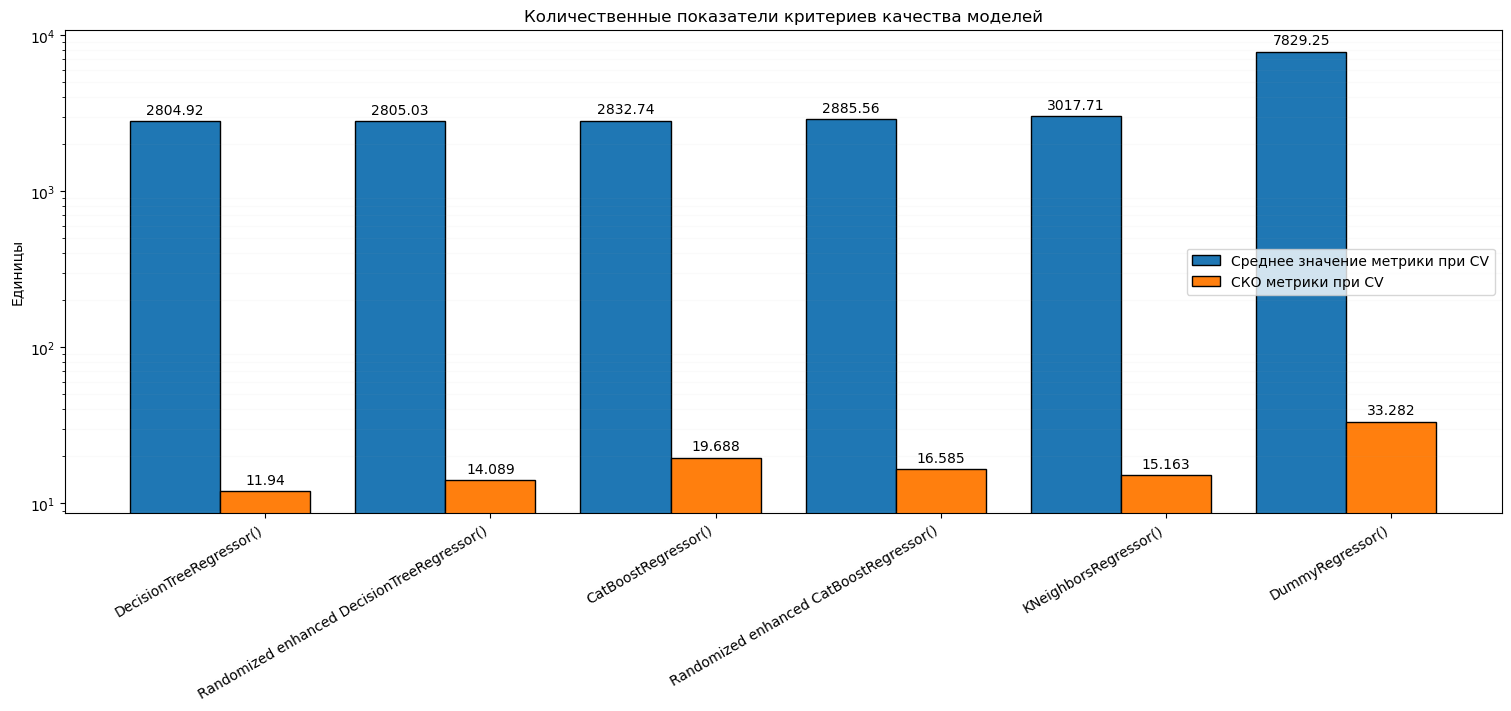

**Д. Произведен анализ разработанных моделей МО**

В результате анализа времени обучения, времени предсказания и качества моделей сделаны следующие выводы:
1. Модель DecisionTreeRegressor() без подбора гиперпараметров превзошла все другие модели по значению метрики.
2. Самая быстрая модель в обучении модель DecisionTreeRegressor() после подбора гиперпараметров.
3. Самая быстро предсказывающая модель - это снова DecisionTreeRegressor() после подбора гиперпараметров.
4. При этом, стабильность указанных моделей также лучшая.

_В связи с изложенным, лучшей моделью для заказчика признана DecisionTreeRegressor() после подбора гиперпараметров:_
1. Быстро обучается - около 0,1 секунды.
2. Быстро предсказывает - около 0.039 секунд.
3. Качественно предсказывает - RMSE составляет 2805.
    
**Е. Оценка качества модели на тестовой выборке**

В результате проведенной работы лучшая модель для заказчика была протестирована. Результаты работы зафиксированы следующие:
1. Метрика RMSE лучшей модели на тестовой выборке: 2812.6312. 
Метрика MAPE лучшей модели на тестовой выборке: 0.2023. 
Время предсказания лучшей модели на тестовой выборке: 0.041Проведена оценка важности признаков. Можно сделать следующие выводы в порядке снижения важности признаков:
- самый важный признак - год выпуска автомобиля. Очевидно, что формирование признака с указанием более точного года выпуска автомобиля увеличить качество модели МО;
- признак завода, на котором был выпущен автомобиль также играет важную роль в формировании стоимости автомобиля. Возможно, объем выпуска автомобилей играет важную роль - чем больше автомобилей выпускалось, тем больше данных для обучения. Кроме того, может репутация заводов играет роль;
- признак модели, характеристик двигателя также немаловажены. Целесообразно расширить данные для обучения подробной расшифровкой указанных признаков.
- World Manufacturer Identifier играет меньшую роль, поскольку представлены автомобили одного производителя. При этом регион выпуска не играет никакой роли.
- Также тип restraint системы играет минимальную роль в оценке стоимости.

Принято решение удалить созданный признак и переобучить модель на оставшихся признаках на полном дата-сете.

**Разработка интефейса взаимодействия клиентов и модели.**

Обученная модель была сохранена и создан класс CarByVin, принимающий строку VIN-кодов, разделенных пробелом, и возвращающий список невалидных VIN-кодов и предсказанную стоимость автомобиля.

**Дальнейшая работа**

С учетом проведенной работы полагается целесообразным осущесвить следующую доработку:
1. Раширить данный для обучения VIN-кодами других производителей.
2. Использовать дополнительные признаки, разрабатываемые на основе зашифрованных характеристик в VIN-кодах.
3. Доработать интрефейс взаимодействия клиентов и модели (раширить класс для полной проверки на валидность и отображения характеристик автомобилей).
4. Реализовать веб-приложение, демонстрирующее работу модели. Например, с использованием streamlit.в: